<a href="https://colab.research.google.com/github/18woodwj/CIS-545-Final-Project/blob/main/Copy_of_545_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **545 Final Project**

**Group Members**: John Woodward, Daniel Barra, Julia Thompson

**Datasets**:

- Glassdoor Job Reviews: https://www.kaggle.com/datasets/davidgauthier/glassdoor-job-reviews
- Labour Market UK: https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/employmentandemployeetypes/bulletins/regionallabourmarket/previousReleases?page=1




In [ ]:
# Sklearn and Pandas Setup
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split

In [ ]:
!apt update

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://security.ubuntu.c

In [ ]:
# Run this cell to mount your drive (you will be prompted to sign in)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Create the kaggle directory and read the uploaded kaggle.json file
# (NOTE: Do NOT run this cell more than once unless restarting kernel)
!mkdir ~/.kaggle

In [ ]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
# Download glassdoor data to drive
!!kaggle datasets download -d davidgauthier/glassdoor-job-reviews

['Downloading glassdoor-job-reviews.zip to /content',
 '',
 '  0% 0.00/83.9M [00:00<?, ?B/s]',
 '  6% 5.00M/83.9M [00:00<00:01, 45.8MB/s]',
 ' 32% 27.0M/83.9M [00:00<00:00, 145MB/s] ',
 ' 54% 45.0M/83.9M [00:00<00:00, 164MB/s]',
 ' 73% 61.0M/83.9M [00:00<00:00, 157MB/s]',
 '',
 '100% 83.9M/83.9M [00:00<00:00, 167MB/s]']

In [ ]:
# Unzip the glassdoor data
!unzip /content/glassdoor-job-reviews.zip

Archive:  /content/glassdoor-job-reviews.zip
  inflating: glassdoor_reviews.csv   


In [ ]:
# Read the csv files into dataframes
df_glassdoor = pd.read_csv('/content/glassdoor_reviews.csv')
df_uk_regions = pd.read_csv('https://raw.githubusercontent.com/juliatho/5450_final/main/uk-counties-to-regions.csv')
df_shapefile = pd.read_csv('https://raw.githubusercontent.com/juliatho/5450_final/main/uk_shapefile.csv')
df_uk_unemp = pd.read_csv('https://raw.githubusercontent.com/juliatho/5450_final/main/MoM%20UK%20Unemployment%20by%20Region.csv')

# 1. Preprocessing

## 1.1 'df_uk_unemp' Processing

Here we process the unemployment data such that the regions and dates are all in the correct format

In [ ]:
# Check the unemp data types
print(df_uk_unemp.dtypes)
df_uk_unemp

Region                object
Quarterly Change     float64
Unemployment Rate    float64
Date                  object
dtype: object


,Region,Quarterly Change,Unemployment Rate,Date
0,North East,-0.6,5.2,1/1/2018
1,North West,-0.4,4.0,1/1/2018
2,Yorkshire and The Humber,0.3,5.0,1/1/2018
3,East Midlands,-0.1,4.1,1/1/2018
4,West Midlands,0.2,5.5,1/1/2018
...,...,...,...,...
793,South \nEast,-0.6,3.0,11/1/2022
794,South \nWest,-0.3,2.5,11/1/2022
795,Wales,-0.1,3.7,11/1/2022
796,Scotland,0.3,3.5,11/1/2022


In [ ]:
# Print the unique regions
print(df_uk_unemp['Region'].unique())
# Check for null values
print(df_uk_unemp['Region'].isna().sum())


['North East' 'North West' 'Yorkshire and The Humber' 'East Midlands'
 'West Midlands' 'East  ' 'London' 'South East' 'South West' 'Wales'
 'Scotland' 'Northern Ireland' 'UK' 'East Â\xa0' 'Great \nBritain'
 'England' 'North \nEast' 'North \nWest' 'Yorkshire \nand\nThe Humber'
 'East \nMidlands' 'West \nMidlands' 'East' 'South \nEast' 'South \nWest'
 'Northern \nIreland']
0


Observe that some regions have newline characters, others are differentiated by improper spacing, and othes contain random characters.

Also note that there are no null values.

We'll correct these errors below and standardize the format to be all lower case.

There should be regions in total. The final series should contain:

```
 ['nort east', 'north west', 'yorkshire and the humber', 'east midlands', 'west midlands', 'east of england', 'london', 'south east', 'south west', 'wales', 'scotland', 'northern ireland']
```


In [ ]:
# Convert all of the regions to lowercase
df_uk_unemp['Region'] = df_uk_unemp['Region'].apply(lambda x: x.lower())
# Replace all newline characters
df_uk_unemp['Region'] = df_uk_unemp['Region'].apply(lambda x: x.replace('\n', ''))
# Correct for trailing spaces
df_uk_unemp['Region'] = df_uk_unemp['Region'].apply(lambda x: x.replace('east  ', 'east'))
# Replace east value with weird characters
df_uk_unemp['Region'] = df_uk_unemp['Region'].apply(lambda x: x.replace('east â\xa0', 'east'))
# Correct for spaces around yorkshire
df_uk_unemp['Region'] = df_uk_unemp['Region'].apply(lambda x: x.replace('yorkshire andthe humber', 'yorkshire and the humber'))
# Drop rows associated with uneccesary regions
df_uk_unemp = df_uk_unemp.loc[(df_uk_unemp['Region'] != 'uk') & (df_uk_unemp['Region'] != 'great britain') & (df_uk_unemp['Region'] != 'england')]
# Print the cleaned 'Regions'
print(df_uk_unemp['Region'].unique())
print(df_uk_unemp['Region'].unique().size)

['north east' 'north west' 'yorkshire and the humber' 'east midlands'
 'west midlands' 'east' 'london' 'south east' 'south west' 'wales'
 'scotland' 'northern ireland']
12


We convert the 'Date' attribute to a datetime object

In [ ]:
df_uk_unemp['Date']= pd.to_datetime(df_uk_unemp['Date'], infer_datetime_format = True)
print(df_uk_unemp)

                       Region  Quarterly Change  Unemployment Rate       Date
0                  north east              -0.6                5.2 2018-01-01
1                  north west              -0.4                4.0 2018-01-01
2    yorkshire and the humber               0.3                5.0 2018-01-01
3               east midlands              -0.1                4.1 2018-01-01
4               west midlands               0.2                5.5 2018-01-01
..                        ...               ...                ...        ...
793                south east              -0.6                3.0 2022-11-01
794                south west              -0.3                2.5 2022-11-01
795                     wales              -0.1                3.7 2022-11-01
796                  scotland               0.3                3.5 2022-11-01
797          northern ireland               0.3                3.0 2022-11-01

[696 rows x 4 columns]


<ipython-input-13-64f0501ea252>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uk_unemp['Date']= pd.to_datetime(df_uk_unemp['Date'], infer_datetime_format = True)


Now, let's visualize what the average historical uunemployment rate (as of Jan, 2018) looks like by region

                      Region  Unemployment Rate
0                       east           3.439776
1              east midlands           4.072914
2                     london           5.030638
3                 north east           5.378207
4                 north west           4.223241
5           northern ireland           3.159207
6                   scotland           3.910983
7                 south east           3.407586
8                 south west           3.131034
9                      wales           3.865190
10             west midlands           4.879586
11  yorkshire and the humber           4.519500


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

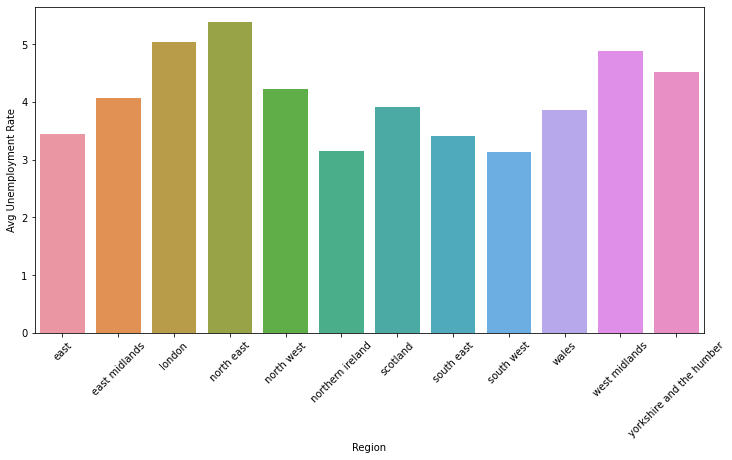

In [ ]:
df_uk_unemp_avg = df_uk_unemp[['Region', 'Unemployment Rate']].groupby(['Region'], as_index = False).mean()
print(df_uk_unemp_avg)
df_uk_unemp_avg = df_uk_unemp_avg.rename(columns = {"Unemployment Rate": "Avg Unemployment Rate"})
# Plot
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(6)
sns.barplot(data = df_uk_unemp_avg, x = 'Region', y = 'Avg Unemployment Rate')
plt.xticks(rotation = 45)

## 1.2 'df_glassdoor' Processing

### 1.2.1 Removing and Formatting Columns

In [ ]:
# Drop null values for locations and dates
df_glassdoor = df_glassdoor.dropna(subset=["location", "date_review"])
# Convert locations and dates to strings
df_glassdoor = df_glassdoor.astype({"location": str, 'date_review': str})
# Convert dates to datetimes
df_glassdoor["date_review"]= pd.to_datetime(df_glassdoor["date_review"], format="%Y-%m-%d")
# Grab those entries from affter Jan, 2018 and save in a new dataframe 'df_glassdoor_recent'
start_time = pd.Timestamp(year=2018, month=1, day=1)
df_glassdoor_recent = df_glassdoor[df_glassdoor['date_review'] >= start_time]

In [ ]:
# Grab only entries in the UK and save in a new data frame df_glassdoor_uk
df_glassdoor_uk = df_glassdoor_recent[df_glassdoor_recent['location'].apply(lambda x: (' England' == x.split(',')[-1] or ' Scotland' == x.split(',')[-1] or ' Northern Ireland' == x.split(',')[-1] or ' Wales' == x.split(',')[-1]))].copy()

In [ ]:
# Save the cities of each review in a new column 'city'
df_glassdoor_uk['city'] = df_glassdoor_uk['location'].apply(lambda x: x.split(',')[0])

In [ ]:
# A function to grab the region from the location attribtue
def classify_region(location):
  if "Wales" in location:
    return "Wales"
  if "Northern Ireland" in location:
    return "Northern Ireland"
  if "Scotland" in location:
    return "Scotland"
  if "West Midlands" in location:
    return "West Midlands"
  if "East Midlands" in location:
    return "East Midlands"
  if "South West" in location:
    return "South West"
  if "London" in location:
    return "London"
  if "East of England" in location:
    return "East of England"
  if "Yorkshire and the Humber" in location:
    return "Yorkshire and the Humber"
  if "South East" in location:
    return "South East"
  if "North East" in location:
    return "North East"
  if "North West" in location:
    return "North West"
  return "None"

In [ ]:
# Save regions in a new column 'region'
df_glassdoor_uk['region'] = df_glassdoor_uk['location'].apply(lambda x: classify_region(x))
df_glassdoor_uk

,firm,date_review,job_title,current,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt,recommend,ceo_approv,outlook,headline,pros,cons,city,region
35,AFH-Wealth-Management,2019-07-28,Financial Advisor Trainee,"Former Employee, less than 1 year","Birmingham, England, England",1,2.0,1.0,NaN,1.0,1.0,1.0,x,r,r,Truly horrific!,Nothing! The whole package was completely mis...,Lack of support to develop. The HR team is a s...,Birmingham,None
36,AFH-Wealth-Management,2019-07-30,Protection Consultant,"Former Employee, less than 1 year","Nottingham, England, England",1,3.0,1.0,NaN,1.0,1.0,1.0,x,x,x,COWBOYS AVOID,hours ok colleagues and line managers are real...,"i worked at their AFH Insure division, give yo...",Nottingham,None
37,AFH-Wealth-Management,2019-08-08,Administrative,"Current Employee, more than 1 year","Bromsgrove, England, England",4,4.0,5.0,NaN,3.0,3.0,5.0,v,o,v,Good place,"Friendly people, almost like a family!","Progression is hard, almost feels like the sup...",Bromsgrove,None
38,AFH-Wealth-Management,2019-08-15,T&C Supervisor,"Current Employee, more than 1 year","Bromsgrove, England, England",5,5.0,5.0,NaN,5.0,4.0,5.0,v,o,v,Forward thinking company with very supportive ...,I joined AFH in December 2017 and have found t...,No cons to speak of,Bromsgrove,None
39,AFH-Wealth-Management,2019-09-12,Financial Advisor,"Current Employee, more than 1 year","Bromsgrove, England, England",5,5.0,5.0,NaN,5.0,5.0,5.0,v,o,v,Fabulous company with fabulous people and grea...,I jumped from a bankassurance world into the w...,Nothing worth mentioning at all.,Bromsgrove,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838537,the-LEGO-Group,2021-04-24,Christmas Temp Customer Assistant,"Former Employee, less than 1 year","Manchester, England, England",3,3.0,5.0,3.0,3.0,5.0,4.0,v,o,r,Good workplace but poor end,"Nice friendly workplace, exciting products, cr...",Did not deal with the topic of whether I was b...,Manchester,None
838539,the-LEGO-Group,2021-04-27,Customer Advisor,"Current Employee, less than 1 year","Slough, Berkshire, South East England, England...",5,5.0,5.0,5.0,5.0,5.0,5.0,v,v,o,Amazing company,"Culturally diverse, lots of opportunities to p...","IT/systems a little backward, this is being wo...",Slough,South East
838543,the-LEGO-Group,2021-05-04,Sales Assistant,"Former Employee, less than 1 year","Birmingham, England, England",5,4.0,4.0,5.0,4.0,5.0,5.0,v,v,v,Lovely place to work,Nice working environment \r\n\r\nGreat perks (...,Very regimented- some aspects of the staff all...,Birmingham,None
838558,the-LEGO-Group,2021-05-25,Senior Product Manager,Current Employee,"London, England, England",4,3.0,4.0,2.0,3.0,2.0,3.0,v,r,v,A great brand,Family owned and a great brand. Danish culture...,"A lot of bureaucracy, hard to make things happ...",London,London


### 1.2.2 Merge with 'df_uk_regions'

Note that a lot of regions are null. To address this, we reference a new dataset connecting counties to regions and then use a web-scraper for any remaining null values, narrowing down the # of entries wihtout regions

In [ ]:
# Print how many unique locations are missing regions
print(len(df_glassdoor_uk[df_glassdoor_uk['region'] == 'None']['location'].unique()))
df_glassdoor_uk[['region', 'date_review']].groupby(by="region", as_index=False).count()



1460


,region,date_review
0,East Midlands,156
1,East of England,2187
2,London,39932
3,None,49060
4,North East,399
5,North West,899
6,Northern Ireland,2144
7,Scotland,7535
8,South East,1360
9,South West,749


In [ ]:
df_uk_regions

,County,Region
0,Guernsey,Crown Dependencies
1,IOM,Crown Dependencies
2,Jersey,Crown Dependencies
3,North East Derbyshire,East Midlands
4,Amber Valley,East Midlands
...,...,...
526,Sheffield,Yorkshire and the Humber
527,South Yorkshire,Yorkshire and the Humber
528,Wakefield,Yorkshire and the Humber
529,West Yorkshire,Yorkshire and the Humber


In [ ]:
df_glassdoor_uk

,firm,date_review,job_title,current,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt,recommend,ceo_approv,outlook,headline,pros,cons,city,region
35,AFH-Wealth-Management,2019-07-28,Financial Advisor Trainee,"Former Employee, less than 1 year","Birmingham, England, England",1,2.0,1.0,NaN,1.0,1.0,1.0,x,r,r,Truly horrific!,Nothing! The whole package was completely mis...,Lack of support to develop. The HR team is a s...,Birmingham,None
36,AFH-Wealth-Management,2019-07-30,Protection Consultant,"Former Employee, less than 1 year","Nottingham, England, England",1,3.0,1.0,NaN,1.0,1.0,1.0,x,x,x,COWBOYS AVOID,hours ok colleagues and line managers are real...,"i worked at their AFH Insure division, give yo...",Nottingham,None
37,AFH-Wealth-Management,2019-08-08,Administrative,"Current Employee, more than 1 year","Bromsgrove, England, England",4,4.0,5.0,NaN,3.0,3.0,5.0,v,o,v,Good place,"Friendly people, almost like a family!","Progression is hard, almost feels like the sup...",Bromsgrove,None
38,AFH-Wealth-Management,2019-08-15,T&C Supervisor,"Current Employee, more than 1 year","Bromsgrove, England, England",5,5.0,5.0,NaN,5.0,4.0,5.0,v,o,v,Forward thinking company with very supportive ...,I joined AFH in December 2017 and have found t...,No cons to speak of,Bromsgrove,None
39,AFH-Wealth-Management,2019-09-12,Financial Advisor,"Current Employee, more than 1 year","Bromsgrove, England, England",5,5.0,5.0,NaN,5.0,5.0,5.0,v,o,v,Fabulous company with fabulous people and grea...,I jumped from a bankassurance world into the w...,Nothing worth mentioning at all.,Bromsgrove,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838537,the-LEGO-Group,2021-04-24,Christmas Temp Customer Assistant,"Former Employee, less than 1 year","Manchester, England, England",3,3.0,5.0,3.0,3.0,5.0,4.0,v,o,r,Good workplace but poor end,"Nice friendly workplace, exciting products, cr...",Did not deal with the topic of whether I was b...,Manchester,None
838539,the-LEGO-Group,2021-04-27,Customer Advisor,"Current Employee, less than 1 year","Slough, Berkshire, South East England, England...",5,5.0,5.0,5.0,5.0,5.0,5.0,v,v,o,Amazing company,"Culturally diverse, lots of opportunities to p...","IT/systems a little backward, this is being wo...",Slough,South East
838543,the-LEGO-Group,2021-05-04,Sales Assistant,"Former Employee, less than 1 year","Birmingham, England, England",5,4.0,4.0,5.0,4.0,5.0,5.0,v,v,v,Lovely place to work,Nice working environment \r\n\r\nGreat perks (...,Very regimented- some aspects of the staff all...,Birmingham,None
838558,the-LEGO-Group,2021-05-25,Senior Product Manager,Current Employee,"London, England, England",4,3.0,4.0,2.0,3.0,2.0,3.0,v,r,v,A great brand,Family owned and a great brand. Danish culture...,"A lot of bureaucracy, hard to make things happ...",London,London


In [ ]:
# For every entry where region is null, merge on city and country to grab more regions
df_glassdoor_merged_region = df_glassdoor_uk[df_glassdoor_uk["region"] == "None"].merge(df_uk_regions, how = "left", left_on="city", right_on="County")
# Grab all of the reviews for which region is still N/A
df_glassdoor_unclassified = df_glassdoor_merged_region[df_glassdoor_merged_region["Region"].isna()]
# Grab all of the reviews for which region is not N/A
df_glassdoor_known = df_glassdoor_merged_region[df_glassdoor_merged_region["Region"].notna()]
df_glassdoor_unclassified


,firm,date_review,job_title,current,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,...,recommend,ceo_approv,outlook,headline,pros,cons,city,region,County,Region
19,AFH-Wealth-Management,2021-05-13,Mortgage and Protection Advisor,"Former Employee, more than 1 year","Taunton, England, England",5,5.0,5.0,5.0,5.0,...,o,o,o,Mortgage Advisor,Good company to work for,Communication between departments is lacking,Taunton,None,NaN,NaN
21,AJ-Bell,2018-05-21,Team Leader,"Current Employee, more than 3 years","Royal Tunbridge Wells, England, England",4,5.0,4.0,NaN,5.0,...,v,r,v,Good Company,Great atmosphere and you can speak to people o...,systems need a lot of work,Royal Tunbridge Wells,None,NaN,NaN
22,AJ-Bell,2018-09-10,Transfers Administrator,"Former Employee, more than 1 year","Royal Tunbridge Wells, England, England",5,5.0,5.0,NaN,5.0,...,v,x,v,Transfers Administrator,"Everything - great team, fair work loads, lots...",None - only reason I left was they closed the ...,Royal Tunbridge Wells,None,NaN,NaN
25,AJ-Bell,2020-02-29,Pension Administrator,"Former Employee, more than 3 years","Trafford Park, England, England",3,3.0,3.0,NaN,1.0,...,v,r,r,Great starter job but don't stay,Great pensions training but no progression.,Poor company pension - for a pension company!\...,Trafford Park,None,NaN,NaN
41,AJ-Bell,2020-07-28,Software Tester,"Former Employee, more than 1 year","Highbury, England, England",5,5.0,5.0,NaN,4.0,...,v,v,v,VERY GOOD COMPANY TO WORK WITH,"Good work culture, adaptive and professional",Salary wise not much productive,Highbury,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49346,next,2021-06-02,Warehouse Worker,"Former Employee, more than 5 years","South Elmsall, England, England",5,5.0,5.0,5.0,5.0,...,v,v,v,Great,"Breaks, food, wage, holidays, Christmas","Flex, hours, guards, trainers, pool",South Elmsall,None,NaN,NaN
49348,next,2021-06-03,Stockroom Assistant,"Former Employee, more than 5 years","Fleetwood, England, England",3,3.0,1.0,1.0,1.0,...,x,r,r,Easy but physically challenging work,Employee discount and generous uniform subsidy,"poor management, no overtime pay",Fleetwood,None,NaN,NaN
49353,the-LEGO-Group,2018-07-11,Guest Experience Host,"Former Employee, more than 1 year","Manchester City Centre, England, England",4,5.0,4.0,NaN,4.0,...,v,o,v,Guest Experience Host (Rides),"Great team, fun job, gain experience with kids...","In-house drama 24/7, lack of communication bet...",Manchester City Centre,None,NaN,NaN
49354,the-LEGO-Group,2019-04-30,Sales Assistant,"Current Employee, more than 1 year","Brighton, England, England",5,5.0,5.0,NaN,2.0,...,v,v,v,Review for the Lego Group,"Great work environment, really fun.",not many career opportunities on site.,Brighton,None,NaN,NaN


### 1.2.3 Use a we scraper to fill in any additional missing regions

In [ ]:
crawl_list = []

for city in df_glassdoor_unclassified['city'].unique():
  crawl_list.append('https://en.wikipedia.org/wiki/' + city.replace(' ', '_').replace('-', '_'))

print(crawl_list)

['https://en.wikipedia.org/wiki/Taunton', 'https://en.wikipedia.org/wiki/Royal_Tunbridge_Wells', 'https://en.wikipedia.org/wiki/Trafford_Park', 'https://en.wikipedia.org/wiki/Highbury', 'https://en.wikipedia.org/wiki/Manchester_City_Centre', 'https://en.wikipedia.org/wiki/Market_Harborough', 'https://en.wikipedia.org/wiki/Ellesmere_Port', 'https://en.wikipedia.org/wiki/Crewe', 'https://en.wikipedia.org/wiki/Weston_super_Mare', 'https://en.wikipedia.org/wiki/Margate', 'https://en.wikipedia.org/wiki/Debden', 'https://en.wikipedia.org/wiki/Long_Eaton', 'https://en.wikipedia.org/wiki/Didcot', 'https://en.wikipedia.org/wiki/Didsbury', 'https://en.wikipedia.org/wiki/Workington', 'https://en.wikipedia.org/wiki/Atherstone', 'https://en.wikipedia.org/wiki/Pitsea', 'https://en.wikipedia.org/wiki/Newcastle_upon_Tyne', 'https://en.wikipedia.org/wiki/Sandbach', 'https://en.wikipedia.org/wiki/Whitehaven', 'https://en.wikipedia.org/wiki/Stourbridge', 'https://en.wikipedia.org/wiki/Telford', 'https://

In [ ]:
import urllib
import urllib.request
import time
pages = []
from lxml import etree
import datetime
city_scrape_df = pd.DataFrame(columns=['city','page','region'])

for url in crawl_list:
    page = url.split("/")[-1] #extract the person name at the end of the url
    print('Looking at file %s' % page)

    # An issue: some of the accent characters won't work.  We need to convert them
    # into an HTML URL.  We'll split the URL, then use "parse.quote" to change
    # the structure, then re-form the URL
    url_list = list(urllib.parse.urlsplit(url))
    url_list[2] = urllib.parse.quote(url_list[2])
    url_ascii = urllib.parse.urlunsplit(url_list)
    try:
      page = urllib.request.urlopen((url_ascii))
      #Save page and url for later use.
      tree = etree.HTML(page.read().decode("utf-8"))  #create a DOM tree of the page
      if (tree == None):
        print('here')
        continue
      url = page.geturl()
      region = 'none'
      city = url[url.rfind('/')+1:] # The part of the URL after the last /
      if (len(tree.xpath('//table[contains(@class,"vcard")]//a[@title="South West England"]/text()')) > 0):
        region = 'south west'
      elif(len(tree.xpath('//table[contains(@class,"vcard")]//a[@title="South East England"]/text()')) > 0):
        region = 'south east'
      elif(len(tree.xpath('//table[contains(@class,"vcard")]//a[@title="West Midlands (region)"]/text()')) > 0):
        region = 'west midlands'
      elif(len(tree.xpath('//table[contains(@class,"vcard")]//a[@title="North West England"]/text()')) > 0):
        region = 'north west'
      elif(len(tree.xpath('//table[contains(@class,"vcard")]//a[@title="East of England"]/text()')) > 0):
        region = 'east of england'
      elif(len(tree.xpath('//table[contains(@class,"vcard")]//a[@title="Yorkshire and the Humber"]/text()')) > 0):
        region = 'yorkshire and the humber'
      elif(len(tree.xpath('//table[contains(@class,"vcard")]//a[@title="East Midlands"]/text()')) > 0):
        region = 'east midlands'
      elif(len(tree.xpath('//table[contains(@class,"vcard")]//a[@title="Greater London"]/text()')) > 0):
        region = 'london'
      elif(len(tree.xpath('//table[contains(@class,"vcard")]//a[@title="North East England"]/text()')) > 0):
        region = 'north east'
      city_scrape_df = city_scrape_df.append({'city': city, 'page': url,
                    'region': region}, ignore_index=True)
    except urllib.error.URLError as e:
      print(e.reason)


Looking at file Taunton
Looking at file Royal_Tunbridge_Wells
Looking at file Trafford_Park
Looking at file Highbury
Looking at file Manchester_City_Centre
Looking at file Market_Harborough
Looking at file Ellesmere_Port
Looking at file Crewe
Looking at file Weston_super_Mare
Looking at file Margate
Looking at file Debden
Looking at file Long_Eaton
Looking at file Didcot
Looking at file Didsbury
Looking at file Workington
Looking at file Atherstone
Looking at file Pitsea
Looking at file Newcastle_upon_Tyne
Looking at file Sandbach
Looking at file Whitehaven
Looking at file Stourbridge
Looking at file Telford
Looking at file Romford
Looking at file Hull
Looking at file Guiseley
Looking at file Loughborough
Looking at file Catford
Looking at file Consett
Looking at file Blackburn
Looking at file Brighton
Looking at file Queenborough
Looking at file Camborne
Looking at file Chatteris
Looking at file Dronfield
Looking at file Chipping_Norton
Looking at file Chester
Looking at file Northfie

In [ ]:
city_scrape_df

,city,page,region
0,Taunton,https://en.wikipedia.org/wiki/Taunton,south west
1,Royal_Tunbridge_Wells,https://en.wikipedia.org/wiki/Royal_Tunbridge_...,south east
2,Trafford_Park,https://en.wikipedia.org/wiki/Trafford_Park,north west
3,Highbury,https://en.wikipedia.org/wiki/Highbury,london
4,Manchester_City_Centre,https://en.wikipedia.org/wiki/Manchester_City_...,north west
...,...,...,...
1304,Burnham,https://en.wikipedia.org/wiki/Burnham,none
1305,Enderby,https://en.wikipedia.org/wiki/Enderby,none
1306,Wath,https://en.wikipedia.org/wiki/Wath,none
1307,Stansted_Mountfitchet,https://en.wikipedia.org/wiki/Stansted_Mountfi...,east of england


In [ ]:
city_scrape_df[city_scrape_df['region'] == 'none']

,city,page,region
10,Debden,https://en.wikipedia.org/wiki/Debden,none
23,Hull,https://en.wikipedia.org/wiki/Hull,none
36,Northfield,https://en.wikipedia.org/wiki/Northfield,none
40,Gillingham,https://en.wikipedia.org/wiki/Gillingham,none
60,Hyde,https://en.wikipedia.org/wiki/Hyde,none
...,...,...,...
1269,Tyseley,https://en.wikipedia.org/wiki/Tyseley,none
1283,Botley,https://en.wikipedia.org/wiki/Botley,none
1304,Burnham,https://en.wikipedia.org/wiki/Burnham,none
1305,Enderby,https://en.wikipedia.org/wiki/Enderby,none


In [ ]:
df_glassdoor_classified = df_glassdoor_unclassified.merge(right=city_scrape_df, how="left", left_on="city", right_on="city")
df_glassdoor_classified = df_glassdoor_classified.drop(axis = 1, labels=['region_x', 'County', 'Region', 'page']).rename(columns={"region_y": "region"})
df_glassdoor_classified['region'] = df_glassdoor_classified['region'].fillna('none')

In [ ]:
# Drop unecessary columns from known
df_glassdoor_known = df_glassdoor_known.drop(axis = 1, labels=['region', 'County',]).rename(columns={"Region": "region"})
df_glassdoor_known


,firm,date_review,job_title,current,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt,recommend,ceo_approv,outlook,headline,pros,cons,city,region
0,AFH-Wealth-Management,2019-07-28,Financial Advisor Trainee,"Former Employee, less than 1 year","Birmingham, England, England",1,2.0,1.0,NaN,1.0,1.0,1.0,x,r,r,Truly horrific!,Nothing! The whole package was completely mis...,Lack of support to develop. The HR team is a s...,Birmingham,West Midlands
1,AFH-Wealth-Management,2019-07-30,Protection Consultant,"Former Employee, less than 1 year","Nottingham, England, England",1,3.0,1.0,NaN,1.0,1.0,1.0,x,x,x,COWBOYS AVOID,hours ok colleagues and line managers are real...,"i worked at their AFH Insure division, give yo...",Nottingham,East Midlands
2,AFH-Wealth-Management,2019-08-08,Administrative,"Current Employee, more than 1 year","Bromsgrove, England, England",4,4.0,5.0,NaN,3.0,3.0,5.0,v,o,v,Good place,"Friendly people, almost like a family!","Progression is hard, almost feels like the sup...",Bromsgrove,West Midlands
3,AFH-Wealth-Management,2019-08-15,T&C Supervisor,"Current Employee, more than 1 year","Bromsgrove, England, England",5,5.0,5.0,NaN,5.0,4.0,5.0,v,o,v,Forward thinking company with very supportive ...,I joined AFH in December 2017 and have found t...,No cons to speak of,Bromsgrove,West Midlands
4,AFH-Wealth-Management,2019-09-12,Financial Advisor,"Current Employee, more than 1 year","Bromsgrove, England, England",5,5.0,5.0,NaN,5.0,5.0,5.0,v,o,v,Fabulous company with fabulous people and grea...,I jumped from a bankassurance world into the w...,Nothing worth mentioning at all.,Bromsgrove,West Midlands
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49358,the-LEGO-Group,2021-02-19,Lego Brick Specialist,"Former Employee, more than 1 year","Sheffield, England, England",5,NaN,NaN,NaN,NaN,NaN,NaN,o,o,o,Good,+Great Discount on Lego products (50% off),-No full time contracts. Most people on just 1...,Sheffield,Yorkshire and the Humber
49359,the-LEGO-Group,2021-03-25,Senior Manager,Current Employee,"Woking, England, England",5,4.0,5.0,5.0,3.0,4.0,4.0,v,v,v,"Incredible company with hear, soul, great bran...","Great values, innovative thinking, genuine care",Opportunities to move around can be limited,Woking,South East England
49360,the-LEGO-Group,2021-04-06,Sales Associate,"Current Employee, more than 1 year","Gateshead, England, England",5,5.0,5.0,5.0,3.0,5.0,5.0,v,v,v,Love the company,"Great company, supportive of mental health iss...",Not much opportunity to move upwards within th...,Gateshead,North East England
49362,the-LEGO-Group,2021-04-24,Christmas Temp Customer Assistant,"Former Employee, less than 1 year","Manchester, England, England",3,3.0,5.0,3.0,3.0,5.0,4.0,v,o,r,Good workplace but poor end,"Nice friendly workplace, exciting products, cr...",Did not deal with the topic of whether I was b...,Manchester,North West England


In [ ]:
# Concat the known and classfieid dataframes
df_glassdoor_with_regions = pd.concat(objs = [df_glassdoor_known, df_glassdoor_classified, df_glassdoor_uk[df_glassdoor_uk["region"] != "none"]])

In [ ]:
df_glassdoor_with_regions

,firm,date_review,job_title,current,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt,recommend,ceo_approv,outlook,headline,pros,cons,city,region
0,AFH-Wealth-Management,2019-07-28,Financial Advisor Trainee,"Former Employee, less than 1 year","Birmingham, England, England",1,2.0,1.0,NaN,1.0,1.0,1.0,x,r,r,Truly horrific!,Nothing! The whole package was completely mis...,Lack of support to develop. The HR team is a s...,Birmingham,West Midlands
1,AFH-Wealth-Management,2019-07-30,Protection Consultant,"Former Employee, less than 1 year","Nottingham, England, England",1,3.0,1.0,NaN,1.0,1.0,1.0,x,x,x,COWBOYS AVOID,hours ok colleagues and line managers are real...,"i worked at their AFH Insure division, give yo...",Nottingham,East Midlands
2,AFH-Wealth-Management,2019-08-08,Administrative,"Current Employee, more than 1 year","Bromsgrove, England, England",4,4.0,5.0,NaN,3.0,3.0,5.0,v,o,v,Good place,"Friendly people, almost like a family!","Progression is hard, almost feels like the sup...",Bromsgrove,West Midlands
3,AFH-Wealth-Management,2019-08-15,T&C Supervisor,"Current Employee, more than 1 year","Bromsgrove, England, England",5,5.0,5.0,NaN,5.0,4.0,5.0,v,o,v,Forward thinking company with very supportive ...,I joined AFH in December 2017 and have found t...,No cons to speak of,Bromsgrove,West Midlands
4,AFH-Wealth-Management,2019-09-12,Financial Advisor,"Current Employee, more than 1 year","Bromsgrove, England, England",5,5.0,5.0,NaN,5.0,5.0,5.0,v,o,v,Fabulous company with fabulous people and grea...,I jumped from a bankassurance world into the w...,Nothing worth mentioning at all.,Bromsgrove,West Midlands
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838537,the-LEGO-Group,2021-04-24,Christmas Temp Customer Assistant,"Former Employee, less than 1 year","Manchester, England, England",3,3.0,5.0,3.0,3.0,5.0,4.0,v,o,r,Good workplace but poor end,"Nice friendly workplace, exciting products, cr...",Did not deal with the topic of whether I was b...,Manchester,None
838539,the-LEGO-Group,2021-04-27,Customer Advisor,"Current Employee, less than 1 year","Slough, Berkshire, South East England, England...",5,5.0,5.0,5.0,5.0,5.0,5.0,v,v,o,Amazing company,"Culturally diverse, lots of opportunities to p...","IT/systems a little backward, this is being wo...",Slough,South East
838543,the-LEGO-Group,2021-05-04,Sales Assistant,"Former Employee, less than 1 year","Birmingham, England, England",5,4.0,4.0,5.0,4.0,5.0,5.0,v,v,v,Lovely place to work,Nice working environment \r\n\r\nGreat perks (...,Very regimented- some aspects of the staff all...,Birmingham,None
838558,the-LEGO-Group,2021-05-25,Senior Product Manager,Current Employee,"London, England, England",4,3.0,4.0,2.0,3.0,2.0,3.0,v,r,v,A great brand,Family owned and a great brand. Danish culture...,"A lot of bureaucracy, hard to make things happ...",London,London


In [ ]:
# Print the top 15 cities that do not have a region
df_glassdoor_with_regions[df_glassdoor_with_regions["region"] == "none"][['city', 'region']].groupby(by="city", as_index = False).count().sort_values(by="region", ascending=False).head(15)

,city,region
360,Newcastle upon Tyne,1291
358,Newcastle,331
313,Manchester City Centre,314
357,Newbury,311
43,Bath,290
529,Welwyn Garden City,265
261,Hull,191
249,High Wycombe,152
220,Halifax,119
239,Hemel Hempstead,116


In [ ]:
# Manually fix all cities missing regions with greater than 100 entries
def fix_nones(row):
  if (row['city'] == "Newcastle" or row['city'] == "Newcastle upon Tyne"):
    row['region'] = "north east"
  if (row['city'] == "Machester City Centre" or row['city'] == "Newcastle upon Tyne"):
    row['region'] = "north west"
  if (row['city'] == "Newcastle" or row['city'] == "Bath" or row['city'] == "Andover" or row['city'] == "Newbury" or  row['city'] == "High Wycombe"):
    row['region'] = "south east"
  if (row['city'] == "Hull" or row['city'] == "Halifax"):
    row['region'] = "yorkshire and the humber"
  if (row['city'] == "Welwyn Garden City"or row['city'] == "Hemel Hempstead"):
    row['region'] = "east of england"
  return row
df_glassdoor_with_regions = df_glassdoor_with_regions.apply(lambda x: fix_nones(x), axis = 1)

In [ ]:
# Convert all regions to lowercase and remove all etnries not paired with region
df_glassdoor_with_regions['region'] = df_glassdoor_with_regions['region'].apply(lambda x: x.lower())
df_glassdoor_with_regions = df_glassdoor_with_regions[df_glassdoor_with_regions['region'] != 'none']
df_glassdoor_with_regions

,firm,date_review,job_title,current,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt,recommend,ceo_approv,outlook,headline,pros,cons,city,region
0,AFH-Wealth-Management,2019-07-28,Financial Advisor Trainee,"Former Employee, less than 1 year","Birmingham, England, England",1,2.0,1.0,NaN,1.0,1.0,1.0,x,r,r,Truly horrific!,Nothing! The whole package was completely mis...,Lack of support to develop. The HR team is a s...,Birmingham,west midlands
1,AFH-Wealth-Management,2019-07-30,Protection Consultant,"Former Employee, less than 1 year","Nottingham, England, England",1,3.0,1.0,NaN,1.0,1.0,1.0,x,x,x,COWBOYS AVOID,hours ok colleagues and line managers are real...,"i worked at their AFH Insure division, give yo...",Nottingham,east midlands
2,AFH-Wealth-Management,2019-08-08,Administrative,"Current Employee, more than 1 year","Bromsgrove, England, England",4,4.0,5.0,NaN,3.0,3.0,5.0,v,o,v,Good place,"Friendly people, almost like a family!","Progression is hard, almost feels like the sup...",Bromsgrove,west midlands
3,AFH-Wealth-Management,2019-08-15,T&C Supervisor,"Current Employee, more than 1 year","Bromsgrove, England, England",5,5.0,5.0,NaN,5.0,4.0,5.0,v,o,v,Forward thinking company with very supportive ...,I joined AFH in December 2017 and have found t...,No cons to speak of,Bromsgrove,west midlands
4,AFH-Wealth-Management,2019-09-12,Financial Advisor,"Current Employee, more than 1 year","Bromsgrove, England, England",5,5.0,5.0,NaN,5.0,5.0,5.0,v,o,v,Fabulous company with fabulous people and grea...,I jumped from a bankassurance world into the w...,Nothing worth mentioning at all.,Bromsgrove,west midlands
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838529,the-LEGO-Group,2021-04-15,Customer Service,Current Employee,"Slough, Berkshire, South East England, England...",5,NaN,NaN,NaN,NaN,NaN,NaN,o,o,o,The company I want to work for my life,"Friendly colleagues, caring decision-makers, a...",Sometimes it takes a while to improve system/r...,Slough,south east
838534,the-LEGO-Group,2021-04-20,Social Media,"Current Employee, more than 1 year","London, England, England",5,5.0,4.0,5.0,3.0,4.0,5.0,v,v,v,"Stable, exciting and rewarding",It’s a fantastic company with great values and...,The work life balance is very important which ...,London,london
838539,the-LEGO-Group,2021-04-27,Customer Advisor,"Current Employee, less than 1 year","Slough, Berkshire, South East England, England...",5,5.0,5.0,5.0,5.0,5.0,5.0,v,v,o,Amazing company,"Culturally diverse, lots of opportunities to p...","IT/systems a little backward, this is being wo...",Slough,south east
838558,the-LEGO-Group,2021-05-25,Senior Product Manager,Current Employee,"London, England, England",4,3.0,4.0,2.0,3.0,2.0,3.0,v,r,v,A great brand,Family owned and a great brand. Danish culture...,"A lot of bureaucracy, hard to make things happ...",London,london


In [ ]:
df_temp = df_glassdoor_with_regions[['region', 'date_review']].groupby(by="region", as_index=False).count()
df_temp

,region,date_review
0,east midlands,4027
1,east of england,5743
2,london,43033
3,north east,516
4,north east england,994
5,north west,4661
6,north west england,6278
7,northern ireland,2141
8,scotland,7535
9,south east,6604


In [ ]:
# Rename 'north west england' 'south east england' 'north east england' 'south west england' 'east of england'
df_glassdoor_with_regions = df_glassdoor_with_regions.replace({'region': {"east of england": "east", "south east england": "south east", "north west england": "north west", "south west england": "south west", "north east england": "north east"}})

In [ ]:
df_temp = df_glassdoor_with_regions[['region', 'date_review']].groupby(by="region", as_index=False).count()
df_temp

,region,date_review
0,east,5743
1,east midlands,4027
2,london,43033
3,north east,1510
4,north west,10939
5,northern ireland,2141
6,scotland,7535
7,south east,11717
8,south west,5224
9,wales,2258


### 1.2.5 Mean Replacement

In [ ]:
# Replace null values with the average of that column

# Grab the average of each column
avg_bal = df_glassdoor_with_regions['work_life_balance'].mean()
avg_val = df_glassdoor_with_regions['culture_values'].mean()
avg_incl = df_glassdoor_with_regions['diversity_inclusion'].mean()
avg_opp = df_glassdoor_with_regions['career_opp'].mean()
avg_ben = df_glassdoor_with_regions['comp_benefits'].mean()
avg_sen = df_glassdoor_with_regions['senior_mgmt'].mean()

# Replace null values

df_glassdoor_with_regions.loc[df_glassdoor_with_regions['work_life_balance'].isnull(), 'work_life_balance'] = avg_bal
df_glassdoor_with_regions.loc[df_glassdoor_with_regions['culture_values'].isnull(), 'culture_values'] = avg_val
df_glassdoor_with_regions.loc[df_glassdoor_with_regions['diversity_inclusion'].isnull(), 'diversity_inclusion'] = avg_incl
df_glassdoor_with_regions.loc[df_glassdoor_with_regions['career_opp'].isnull(), 'career_opp'] = avg_opp
df_glassdoor_with_regions.loc[df_glassdoor_with_regions['comp_benefits'].isnull(), 'comp_benefits'] = avg_ben
df_glassdoor_with_regions.loc[df_glassdoor_with_regions['senior_mgmt'].isnull(), 'senior_mgmt'] = avg_sen

In [ ]:
df_glassdoor_with_regions
print(df_glassdoor_with_regions.columns)

Index(['firm', 'date_review', 'job_title', 'current', 'location',
       'overall_rating', 'work_life_balance', 'culture_values',
       'diversity_inclusion', 'career_opp', 'comp_benefits', 'senior_mgmt',
       'recommend', 'ceo_approv', 'outlook', 'headline', 'pros', 'cons',
       'city', 'region'],
      dtype='object')


### 1.2.6 Sentiment Analysis

In [ ]:
#NLTK sentiment analysis
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
import operator

analyzer = SentimentIntensityAnalyzer()
df_glassdoor_overall = df_glassdoor_with_regions
df_glassdoor_overall = df_glassdoor_overall.astype({'headline': str})
df_glassdoor_overall["sentiment_score"] = df_glassdoor_overall['headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df_glassdoor_overall['sentiment'] = np.select([df_glassdoor_overall['sentiment_score'] < 0, df_glassdoor_overall['sentiment_score'] == 0, df_glassdoor_overall['sentiment_score'] > 0], ['negative', 'neutral', 'positive'])
df_glassdoor_overall.head(20)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,firm,date_review,job_title,current,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,...,recommend,ceo_approv,outlook,headline,pros,cons,city,region,sentiment_score,sentiment
0,AFH-Wealth-Management,2019-07-28,Financial Advisor Trainee,"Former Employee, less than 1 year","Birmingham, England, England",1,2.00000,1.000000,3.889405,1.000000,...,x,r,r,Truly horrific!,Nothing! The whole package was completely mis...,Lack of support to develop. The HR team is a s...,Birmingham,west midlands,-0.4199,negative
1,AFH-Wealth-Management,2019-07-30,Protection Consultant,"Former Employee, less than 1 year","Nottingham, England, England",1,3.00000,1.000000,3.889405,1.000000,...,x,x,x,COWBOYS AVOID,hours ok colleagues and line managers are real...,"i worked at their AFH Insure division, give yo...",Nottingham,east midlands,-0.2960,negative
2,AFH-Wealth-Management,2019-08-08,Administrative,"Current Employee, more than 1 year","Bromsgrove, England, England",4,4.00000,5.000000,3.889405,3.000000,...,v,o,v,Good place,"Friendly people, almost like a family!","Progression is hard, almost feels like the sup...",Bromsgrove,west midlands,0.4404,positive
3,AFH-Wealth-Management,2019-08-15,T&C Supervisor,"Current Employee, more than 1 year","Bromsgrove, England, England",5,5.00000,5.000000,3.889405,5.000000,...,v,o,v,Forward thinking company with very supportive ...,I joined AFH in December 2017 and have found t...,No cons to speak of,Bromsgrove,west midlands,0.3597,positive
4,AFH-Wealth-Management,2019-09-12,Financial Advisor,"Current Employee, more than 1 year","Bromsgrove, England, England",5,5.00000,5.000000,3.889405,5.000000,...,v,o,v,Fabulous company with fabulous people and grea...,I jumped from a bankassurance world into the w...,Nothing worth mentioning at all.,Bromsgrove,west midlands,0.9274,positive
5,AFH-Wealth-Management,2019-12-03,Manager,"Current Employee, more than 1 year","Bromsgrove, England, England",5,5.00000,5.000000,3.889405,5.000000,...,v,o,v,Excellent employer,AFH really does pride itself on looking after ...,None I can think of.,Bromsgrove,west midlands,0.5719,positive
6,AFH-Wealth-Management,2019-12-10,Change,"Former Employee, more than 1 year","Bromsgrove, England, England",1,3.44923,1.000000,3.889405,3.374391,...,x,o,o,If you have any morals avoid this terrible emp...,The multiple Xmas & Summer events which the CE...,Too many to list unfortunately. IMO and based ...,Bromsgrove,west midlands,-0.7027,negative
7,AFH-Wealth-Management,2020-01-20,Administrator,"Current Employee, more than 3 years","Bromsgrove, England, England",5,5.00000,5.000000,3.889405,5.000000,...,v,o,v,Great Place to Work!,Approachable staff\r\nClient focused\r\nStaff ...,Salary for administration staff needs to be lo...,Bromsgrove,west midlands,0.6588,positive
8,AFH-Wealth-Management,2020-06-05,Back Office Support,"Current Employee, more than 3 years","Bromsgrove, England, England",2,3.44923,3.554153,3.889405,3.374391,...,o,o,o,"A mixed bag, but on balance more negative than...",A growing and profitable company.\r\nFlexible ...,"Autocratic, very much a “my way or the highway...",Bromsgrove,west midlands,-0.0500,negative
9,AFH-Wealth-Management,2020-06-08,Anonymous Employee,"Former Employee, less than 1 year","Bromsgrove, England, England",1,3.00000,1.000000,3.889405,1.000000,...,x,o,x,Avoid,Working hours \r\nSome of the people you work ...,Supervisor made me very uneasy from the start ...,Bromsgrove,west midlands,-0.2960,negative


In [ ]:
# Finally let's drop any null values from the overall dataset
df_glassdoor_overall = df_glassdoor_overall.dropna()

### 1.2.7 Add Unemployment Rates

At the point, we've cleaned all of our data, extracted egions, repaced null quantities with the mean for that attribute, and added sentiment scores for each review.

Before proceeding, we need to merge our review data with our unemployment data processed earlier.

Unemployment data is strutured such that we get a monthly unemployment rate for each region. Review data, by comparison, contains data on a daily basis. We need to define a function such that for every review in a particular month and year, we associate the same unemployment data point.

In [ ]:
# declare a new column for unemployemnt rates in glassdoor
df_glassdoor_overall['u_rate'] = 0.0

<ipython-input-42-edb0c0b46b10>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_glassdoor_overall['u_rate'] = 0.0


In [ ]:
# Define a function that for a given month and year of a review in glassdoor, grab the unemployment rate from df_uk_unemp
def find_unemp(row):
  date = row['date_review']
  for ind in df_uk_unemp.index:
    if date.year == df_uk_unemp['Date'][ind].year and date.month == df_uk_unemp['Date'][ind].month and row['region'] == df_uk_unemp['Region'][ind]:
      # the year and the month match for a row, update unemp value
      row['u_rate'] = df_uk_unemp['Unemployment Rate'][ind]
      print(row['u_rate'])
      break
  return row;


In [ ]:
df_glassdoor_overall

,firm,date_review,job_title,current,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,...,ceo_approv,outlook,headline,pros,cons,city,region,sentiment_score,sentiment,u_rate
0,AFH-Wealth-Management,2019-07-28,Financial Advisor Trainee,"Former Employee, less than 1 year","Birmingham, England, England",1,2.00000,1.000000,3.889405,1.000000,...,r,r,Truly horrific!,Nothing! The whole package was completely mis...,Lack of support to develop. The HR team is a s...,Birmingham,west midlands,-0.4199,negative,0.0
1,AFH-Wealth-Management,2019-07-30,Protection Consultant,"Former Employee, less than 1 year","Nottingham, England, England",1,3.00000,1.000000,3.889405,1.000000,...,x,x,COWBOYS AVOID,hours ok colleagues and line managers are real...,"i worked at their AFH Insure division, give yo...",Nottingham,east midlands,-0.2960,negative,0.0
2,AFH-Wealth-Management,2019-08-08,Administrative,"Current Employee, more than 1 year","Bromsgrove, England, England",4,4.00000,5.000000,3.889405,3.000000,...,o,v,Good place,"Friendly people, almost like a family!","Progression is hard, almost feels like the sup...",Bromsgrove,west midlands,0.4404,positive,0.0
3,AFH-Wealth-Management,2019-08-15,T&C Supervisor,"Current Employee, more than 1 year","Bromsgrove, England, England",5,5.00000,5.000000,3.889405,5.000000,...,o,v,Forward thinking company with very supportive ...,I joined AFH in December 2017 and have found t...,No cons to speak of,Bromsgrove,west midlands,0.3597,positive,0.0
4,AFH-Wealth-Management,2019-09-12,Financial Advisor,"Current Employee, more than 1 year","Bromsgrove, England, England",5,5.00000,5.000000,3.889405,5.000000,...,o,v,Fabulous company with fabulous people and grea...,I jumped from a bankassurance world into the w...,Nothing worth mentioning at all.,Bromsgrove,west midlands,0.9274,positive,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838529,the-LEGO-Group,2021-04-15,Customer Service,Current Employee,"Slough, Berkshire, South East England, England...",5,3.44923,3.554153,3.889405,3.374391,...,o,o,The company I want to work for my life,"Friendly colleagues, caring decision-makers, a...",Sometimes it takes a while to improve system/r...,Slough,south east,0.0772,positive,0.0
838534,the-LEGO-Group,2021-04-20,Social Media,"Current Employee, more than 1 year","London, England, England",5,5.00000,4.000000,5.000000,3.000000,...,v,v,"Stable, exciting and rewarding",It’s a fantastic company with great values and...,The work life balance is very important which ...,London,london,0.8316,positive,0.0
838539,the-LEGO-Group,2021-04-27,Customer Advisor,"Current Employee, less than 1 year","Slough, Berkshire, South East England, England...",5,5.00000,5.000000,5.000000,5.000000,...,v,o,Amazing company,"Culturally diverse, lots of opportunities to p...","IT/systems a little backward, this is being wo...",Slough,south east,0.5859,positive,0.0
838558,the-LEGO-Group,2021-05-25,Senior Product Manager,Current Employee,"London, England, England",4,3.00000,4.000000,2.000000,3.000000,...,r,v,A great brand,Family owned and a great brand. Danish culture...,"A lot of bureaucracy, hard to make things happ...",London,london,0.6249,positive,0.0


In [ ]:
# apply lambda to glassdoor_overall
df_glassdoor_overall = df_glassdoor_overall.apply(lambda x: find_unemp(x), axis = 1)

Streaming output truncated to the last 5000 lines.
6.9
6.9
6.9
6.9
6.9
6.9
6.9
6.9
6.9
6.9
6.9
6.9
6.9
6.9
6.9
6.9
6.9
6.9
6.9
6.9
6.9
6.9
6.9
6.9
6.9
6.9
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
7.2
6.8
6.8
6.8
6.8
6.8
6.8
6.8
6.8
6.8
6.8
6.8
6.8
6.8
6.8
6.8
6.8
6.8
6.8
6.8
6.8
6.8
6.8
6.8
6.8
6.8
6.5
6.5
6.5
6.5
5.0
5.0
4.9
4.7
4.5
4.5
4.5
4.3
4.3
4.3
4.5
4.6
4.6
4.6
4.506
4.312
4.668
4.668
4.668
4.668
4.631
4.631
4.631
5.108
4.981
5.251
5.251
5.251
5.251
5.251
4.545
4.545
4.545
4.545
4.545
6.337
6.9
7.2
7.2
7.2
7.2
7.2
7.2
6.8
6.8
6.8
6.8
4.631
5.108
3.1
3.3
3.4
3.4
3.4
3.4
3.7
3.7
3.8
3.8
3.7
3.7
3.1
3.1
3.1
3.1
3.1
3.3
3.3
3.3
3.2
3.2
3.0
3.0
3.0
3.0
3.0
2.8
2.8
2.8
3.1
3.1
3.1
3.152
3.152
3.094
3.094
3.271
3.133
3.133
3.229
3.229
3.229
2.909

In [ ]:
df_glassdoor_overall.head(5)

,firm,date_review,job_title,current,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,...,ceo_approv,outlook,headline,pros,cons,city,region,sentiment_score,sentiment,u_rate
0,AFH-Wealth-Management,2019-07-28,Financial Advisor Trainee,"Former Employee, less than 1 year","Birmingham, England, England",1,2.0,1.0,3.889405,1.0,...,r,r,Truly horrific!,Nothing! The whole package was completely mis...,Lack of support to develop. The HR team is a s...,Birmingham,west midlands,-0.4199,negative,4.8
1,AFH-Wealth-Management,2019-07-30,Protection Consultant,"Former Employee, less than 1 year","Nottingham, England, England",1,3.0,1.0,3.889405,1.0,...,x,x,COWBOYS AVOID,hours ok colleagues and line managers are real...,"i worked at their AFH Insure division, give yo...",Nottingham,east midlands,-0.2960,negative,4.2
2,AFH-Wealth-Management,2019-08-08,Administrative,"Current Employee, more than 1 year","Bromsgrove, England, England",4,4.0,5.0,3.889405,3.0,...,o,v,Good place,"Friendly people, almost like a family!","Progression is hard, almost feels like the sup...",Bromsgrove,west midlands,0.4404,positive,4.6
3,AFH-Wealth-Management,2019-08-15,T&C Supervisor,"Current Employee, more than 1 year","Bromsgrove, England, England",5,5.0,5.0,3.889405,5.0,...,o,v,Forward thinking company with very supportive ...,I joined AFH in December 2017 and have found t...,No cons to speak of,Bromsgrove,west midlands,0.3597,positive,4.6
4,AFH-Wealth-Management,2019-09-12,Financial Advisor,"Current Employee, more than 1 year","Bromsgrove, England, England",5,5.0,5.0,3.889405,5.0,...,o,v,Fabulous company with fabulous people and grea...,I jumped from a bankassurance world into the w...,Nothing worth mentioning at all.,Bromsgrove,west midlands,0.9274,positive,4.2


# 2. Now let's do some models!



## 2.1 Linear Regression

We want to see whether there is a meaningul correlation between unemployment rates, region, date, outlook, and the overall rating for a given company.

We predict that for a given region variances in outlook and unemploymnt rates over time will have a direct impact on how likely someone is to rate their company favorably. For companies / jobs based out of regions where unemployment is higher (i.e. a worse labor market) and outlook is poorer, you should expect to see lower ratings.

Some things to consider before:


*   Grouping by region may not be granular enough to have any meaningful impact on scores
*   Though high unemployment rates would suggest a worse economy and a poorer labor market, the differences in the unemploymnet rate by region from 2018 - present haven't been drastic enough to have any meaningful impact on the majority of jobs.



In [ ]:
# Drop location becasue we don't need
df_glassdoor_overall = df_glassdoor_overall.drop(columns = ['location'])
df_glassdoor_overall.head(2)

,firm,date_review,job_title,current,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,...,ceo_approv,outlook,headline,pros,cons,city,region,sentiment_score,sentiment,u_rate
0,AFH-Wealth-Management,2019-07-28,Financial Advisor Trainee,"Former Employee, less than 1 year",1,2.0,1.0,3.889405,1.0,1.0,...,r,r,Truly horrific!,Nothing! The whole package was completely mis...,Lack of support to develop. The HR team is a s...,Birmingham,west midlands,-0.4199,negative,4.8
1,AFH-Wealth-Management,2019-07-30,Protection Consultant,"Former Employee, less than 1 year",1,3.0,1.0,3.889405,1.0,1.0,...,x,x,COWBOYS AVOID,hours ok colleagues and line managers are real...,"i worked at their AFH Insure division, give yo...",Nottingham,east midlands,-0.2960,negative,4.2


First let's split into numerical and categorical datasets and see if we can ascertain any correlations between the quantitative values

In [ ]:
# Split based on datatype
numerics_df = df_glassdoor_overall.select_dtypes(include=['int64', 'float64'])
categorical_df  = df_glassdoor_overall.select_dtypes(exclude=['int64', 'float64'])


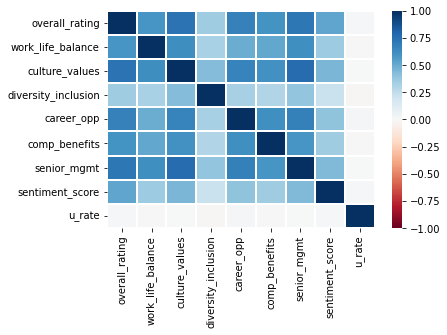

In [ ]:
# Plot the correlation matrix
corr_matrix = numerics_df.corr()
mat_plot = sns.heatmap(corr_matrix, cmap="RdBu", annot=False, vmin = -1, vmax = 1, linewidths = 1)

As you can see, all of our attributes are, for most part, highly posiively correlated except for the unemployment rate.

Also note how overall rating has the strongest correlation with culture values and senior management.

Now we need to consider how our categorical values like region may also contribute to ratings.

In [ ]:
# Get dummies
df_glassdoor_dummies = pd.get_dummies(df_glassdoor_overall, columns = ['recommend', 'ceo_approv', 'outlook', 'region'])
df_glassdoor_dummies.head(5)

,firm,date_review,job_title,current,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,...,region_london,region_north east,region_north west,region_northern ireland,region_scotland,region_south east,region_south west,region_wales,region_west midlands,region_yorkshire and the humber
0,AFH-Wealth-Management,2019-07-28,Financial Advisor Trainee,"Former Employee, less than 1 year",1,2.0,1.0,3.889405,1.0,1.0,...,0,0,0,0,0,0,0,0,1,0
1,AFH-Wealth-Management,2019-07-30,Protection Consultant,"Former Employee, less than 1 year",1,3.0,1.0,3.889405,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,AFH-Wealth-Management,2019-08-08,Administrative,"Current Employee, more than 1 year",4,4.0,5.0,3.889405,3.0,3.0,...,0,0,0,0,0,0,0,0,1,0
3,AFH-Wealth-Management,2019-08-15,T&C Supervisor,"Current Employee, more than 1 year",5,5.0,5.0,3.889405,5.0,4.0,...,0,0,0,0,0,0,0,0,1,0
4,AFH-Wealth-Management,2019-09-12,Financial Advisor,"Current Employee, more than 1 year",5,5.0,5.0,3.889405,5.0,5.0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# Drop job_title, firm, current, pros, cons, headline, sentiment
df_glassdoor_dummies = df_glassdoor_dummies.drop(columns = ['firm', 'job_title', 'current', 'pros', 'cons', 'city', 'headline', 'sentiment'])

In [ ]:
df_glassdoor_dummies.head(2)
df_glassdoor_dummies.columns

Index(['date_review', 'overall_rating', 'work_life_balance', 'culture_values',
       'diversity_inclusion', 'career_opp', 'comp_benefits', 'senior_mgmt',
       'sentiment_score', 'u_rate', 'recommend_o', 'recommend_v',
       'recommend_x', 'ceo_approv_o', 'ceo_approv_r', 'ceo_approv_v',
       'ceo_approv_x', 'outlook_o', 'outlook_r', 'outlook_v', 'outlook_x',
       'region_east', 'region_east midlands', 'region_london',
       'region_north east', 'region_north west', 'region_northern ireland',
       'region_scotland', 'region_south east', 'region_south west',
       'region_wales', 'region_west midlands',
       'region_yorkshire and the humber'],
      dtype='object')

In [ ]:
# Convert the datetime into an int
df_glassdoor_dummies['date_review'] = df_glassdoor_dummies['date_review'].apply(lambda x: int(x.strftime("%Y%m%d")))

Now, let's split our data into training and test sets where are features include all attributes exlcluding the overall rating and including unemployment rate, outlook, and region.

In [ ]:
# Assign features and ratings
features = df_glassdoor_dummies.drop(columns = ['overall_rating'])
ratings = df_glassdoor_dummies['overall_rating']

In [ ]:
seed = 42
x_train, x_test, y_train, y_test = train_test_split(features, ratings, random_state = seed, test_size=0.20)

### 2.1.1 Linear Regression (unreg)

Using scikit-learn, we perform unregularized linear regression on these features



In [ ]:
# Import required libraries
from sklearn.linear_model import LinearRegression

# Initialize model with default parameters and fit it on the training set
reg = LinearRegression()
reg.fit(x_train, y_train)
# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = reg.predict(x_test)
# Find the R-squared score and store the value in `score`
score = reg.score(x_test, y_test)
print(score)

0.7012278831521147


At a ~77% score, we see that there is a fairly strong correlation between these attributes and the overall rating, which makes sense.


### 2.1.2 Ridge Regression

Let's see how adjusting the model to use Redge Regression may change the score. We expect the score to increase, as Ridge Regression is designed to reduce overfitting.

In [ ]:
# Import required libraries
from sklearn.linear_model import Ridge
# Initialize model with alpha = 10 (keep other hyperparameters as default values) and fit it on the training set
reg_ridge = Ridge(alpha = 10.0)
# Use the model to predict on the test set and save these predictions as `y_pred`
reg_ridge.fit(x_train, y_train)
y_pred = reg_ridge.predict(x_test)
# Find the R-squared score and store the value in `ridge_score`
ridge_score = reg_ridge.score(x_test, y_test)
print(ridge_score)

0.7012271957294921


Note tha Ridge Regression barely improved the score, suggesting that our orriginal Linear Regression wasn't overfitting as expecting. Perhaps there is a non-linear relationship between these attributes and overall rating

## 2.2 Logistic Regression

Now let's do some logistic regression to determine whether our selected features can reliably predict whether the sentimnet score for a particular review headline is positive or negative.

In [ ]:
# Define a rating boolean that indicates positive and negative reviews
df_glassdoor_dummies['rating_boolean'] = 0.0
df_glassdoor_dummies.loc[df_glassdoor_dummies['sentiment_score'] >= 0, 'rating_boolean'] = 1.0
df_glassdoor_dummies.head(5)

,date_review,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt,sentiment_score,u_rate,...,region_north east,region_north west,region_northern ireland,region_scotland,region_south east,region_south west,region_wales,region_west midlands,region_yorkshire and the humber,rating_boolean
0,20190728,1,2.0,1.0,3.889405,1.0,1.0,1.0,-0.4199,4.8,...,0,0,0,0,0,0,0,1,0,0.0
1,20190730,1,3.0,1.0,3.889405,1.0,1.0,1.0,-0.2960,4.2,...,0,0,0,0,0,0,0,0,0,0.0
2,20190808,4,4.0,5.0,3.889405,3.0,3.0,5.0,0.4404,4.6,...,0,0,0,0,0,0,0,1,0,1.0
3,20190815,5,5.0,5.0,3.889405,5.0,4.0,5.0,0.3597,4.6,...,0,0,0,0,0,0,0,1,0,1.0
4,20190912,5,5.0,5.0,3.889405,5.0,5.0,5.0,0.9274,4.2,...,0,0,0,0,0,0,0,1,0,1.0


Here we separate out into featues and labels, letting the labels be our rating booleans and features all of the numeric values including on-hot encodings, sentiment score, and a numeric representation of date.

We remove overall_rating since we think it's too highly correlated with sentiment,

In [ ]:
# Grab features of interest
features = df_glassdoor_dummies.drop(columns = ['overall_rating', 'sentiment_score', 'rating_boolean'])
# Grab the rating_boolean as our label
labels = df_glassdoor_dummies['rating_boolean']
features.dtypes


date_review                          int64
work_life_balance                  float64
culture_values                     float64
diversity_inclusion                float64
career_opp                         float64
comp_benefits                      float64
senior_mgmt                        float64
u_rate                             float64
recommend_o                          uint8
recommend_v                          uint8
recommend_x                          uint8
ceo_approv_o                         uint8
ceo_approv_r                         uint8
ceo_approv_v                         uint8
ceo_approv_x                         uint8
outlook_o                            uint8
outlook_r                            uint8
outlook_v                            uint8
outlook_x                            uint8
region_east                          uint8
region_east midlands                 uint8
region_london                        uint8
region_north east                    uint8
region_nort

In [ ]:
# Split into training and test set
# Let seed = 42
seed = 42
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state = seed, test_size=0.20)

Now that we've split inot our training and test sets, let's perform logisitc regression and test accuracy

In [ ]:
# Import required libraries
from sklearn.linear_model import LogisticRegression
# Initialize model with default parameters and fit it on the training set
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = logreg.predict(x_test)
# Find the accuracy and store the value in `log_acc`
log_acc = logreg.score(x_test, y_test)
print(log_acc)

0.8852037236281985


We have ~88% accuracy using the logistic regression model with the features specified, suggesting that the sentiment of each review, as calculated using nltk, is strongly correlated with features such as company outlook, culture, work-life ballance, etc.

### 2.2.1 Factoring Out Regionality

What if we were to drop regions and the unemployment rates for each region? Would this have a meaningful impact on score? We examine this scenario below

In [ ]:
df_glassdoor_dummies.dtypes

date_review                          int64
overall_rating                       int64
work_life_balance                  float64
culture_values                     float64
diversity_inclusion                float64
career_opp                         float64
comp_benefits                      float64
senior_mgmt                        float64
sentiment_score                    float64
u_rate                             float64
recommend_o                          uint8
recommend_v                          uint8
recommend_x                          uint8
ceo_approv_o                         uint8
ceo_approv_r                         uint8
ceo_approv_v                         uint8
ceo_approv_x                         uint8
outlook_o                            uint8
outlook_r                            uint8
outlook_v                            uint8
outlook_x                            uint8
region_east                          uint8
region_east midlands                 uint8
region_lond

In [ ]:
# Grab features of interest
features_u = df_glassdoor_dummies.drop(columns = ['overall_rating', 'sentiment_score', 'rating_boolean', 'u_rate', 'region_east', 'region_east midlands', 'region_london', 'region_north west', 'region_north east', 'region_northern ireland', 'region_scotland', 'region_south east', 'region_south west', 'region_wales', 'region_west midlands', 'region_yorkshire and the humber'])
# Grab the rating_boolean as our label
labels_u = df_glassdoor_dummies['rating_boolean']
features.dtypes

date_review                          int64
work_life_balance                  float64
culture_values                     float64
diversity_inclusion                float64
career_opp                         float64
comp_benefits                      float64
senior_mgmt                        float64
u_rate                             float64
recommend_o                          uint8
recommend_v                          uint8
recommend_x                          uint8
ceo_approv_o                         uint8
ceo_approv_r                         uint8
ceo_approv_v                         uint8
ceo_approv_x                         uint8
outlook_o                            uint8
outlook_r                            uint8
outlook_v                            uint8
outlook_x                            uint8
region_east                          uint8
region_east midlands                 uint8
region_london                        uint8
region_north east                    uint8
region_nort

In [ ]:
# Split into training and test set
# Let seed = 42
seed = 42
x_train, x_test, y_train, y_test = train_test_split(features_u, labels_u, random_state = seed, test_size=0.20)

In [ ]:
# Import required libraries
from sklearn.linear_model import LogisticRegression
# Initialize model with default parameters and fit it on the training set
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = logreg.predict(x_test)
# Find the accuracy and store the value in `log_acc`
log_acc = logreg.score(x_test, y_test)
print(log_acc)

0.8852037236281985


Note that the score doens't change. This suggests that regionality and monthly unemployment over this timeperiod does not have a meaningful correlation with job review sentiment.

## 2.3 How do reviews correlate with regional unemployment

### 2.3.1 First let's look at how review attributes change on a monthly basis in relation to unemployment rates

In [ ]:
df_uk_unemp

,Region,Quarterly Change,Unemployment Rate,Date
0,north east,-0.6,5.2,2018-01-01
1,north west,-0.4,4.0,2018-01-01
2,yorkshire and the humber,0.3,5.0,2018-01-01
3,east midlands,-0.1,4.1,2018-01-01
4,west midlands,0.2,5.5,2018-01-01
...,...,...,...,...
793,south east,-0.6,3.0,2022-11-01
794,south west,-0.3,2.5,2022-11-01
795,wales,-0.1,3.7,2022-11-01
796,scotland,0.3,3.5,2022-11-01


In [ ]:
# Grab the month and the year from df_uk_unemp
df_uk_unemp['month'] = pd.DatetimeIndex(df_uk_unemp['Date']).month
df_uk_unemp['year'] = pd.DatetimeIndex(df_uk_unemp['Date']).year
df_uk_unemp


<ipython-input-67-4ee914670046>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uk_unemp['month'] = pd.DatetimeIndex(df_uk_unemp['Date']).month
<ipython-input-67-4ee914670046>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uk_unemp['year'] = pd.DatetimeIndex(df_uk_unemp['Date']).year


,Region,Quarterly Change,Unemployment Rate,Date,month,year
0,north east,-0.6,5.2,2018-01-01,1,2018
1,north west,-0.4,4.0,2018-01-01,1,2018
2,yorkshire and the humber,0.3,5.0,2018-01-01,1,2018
3,east midlands,-0.1,4.1,2018-01-01,1,2018
4,west midlands,0.2,5.5,2018-01-01,1,2018
...,...,...,...,...,...,...
793,south east,-0.6,3.0,2022-11-01,11,2022
794,south west,-0.3,2.5,2022-11-01,11,2022
795,wales,-0.1,3.7,2022-11-01,11,2022
796,scotland,0.3,3.5,2022-11-01,11,2022


In [ ]:
df_glassdoor_overall.columns

Index(['firm', 'date_review', 'job_title', 'current', 'overall_rating',
       'work_life_balance', 'culture_values', 'diversity_inclusion',
       'career_opp', 'comp_benefits', 'senior_mgmt', 'recommend', 'ceo_approv',
       'outlook', 'headline', 'pros', 'cons', 'city', 'region',
       'sentiment_score', 'sentiment', 'u_rate'],
      dtype='object')

In [ ]:
# Grab the month and the year from df_glassdoor_overall
df_glassdoor_overall['month'] = pd.DatetimeIndex(df_glassdoor_overall['date_review']).month
df_glassdoor_overall['year'] = pd.DatetimeIndex(df_glassdoor_overall['date_review']).year
df_glassdoor_overall


,firm,date_review,job_title,current,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,...,headline,pros,cons,city,region,sentiment_score,sentiment,u_rate,month,year
0,AFH-Wealth-Management,2019-07-28,Financial Advisor Trainee,"Former Employee, less than 1 year",1,2.00000,1.000000,3.889405,1.000000,1.000000,...,Truly horrific!,Nothing! The whole package was completely mis...,Lack of support to develop. The HR team is a s...,Birmingham,west midlands,-0.4199,negative,4.8,7,2019
1,AFH-Wealth-Management,2019-07-30,Protection Consultant,"Former Employee, less than 1 year",1,3.00000,1.000000,3.889405,1.000000,1.000000,...,COWBOYS AVOID,hours ok colleagues and line managers are real...,"i worked at their AFH Insure division, give yo...",Nottingham,east midlands,-0.2960,negative,4.2,7,2019
2,AFH-Wealth-Management,2019-08-08,Administrative,"Current Employee, more than 1 year",4,4.00000,5.000000,3.889405,3.000000,3.000000,...,Good place,"Friendly people, almost like a family!","Progression is hard, almost feels like the sup...",Bromsgrove,west midlands,0.4404,positive,4.6,8,2019
3,AFH-Wealth-Management,2019-08-15,T&C Supervisor,"Current Employee, more than 1 year",5,5.00000,5.000000,3.889405,5.000000,4.000000,...,Forward thinking company with very supportive ...,I joined AFH in December 2017 and have found t...,No cons to speak of,Bromsgrove,west midlands,0.3597,positive,4.6,8,2019
4,AFH-Wealth-Management,2019-09-12,Financial Advisor,"Current Employee, more than 1 year",5,5.00000,5.000000,3.889405,5.000000,5.000000,...,Fabulous company with fabulous people and grea...,I jumped from a bankassurance world into the w...,Nothing worth mentioning at all.,Bromsgrove,west midlands,0.9274,positive,4.2,9,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838529,the-LEGO-Group,2021-04-15,Customer Service,Current Employee,5,3.44923,3.554153,3.889405,3.374391,3.383198,...,The company I want to work for my life,"Friendly colleagues, caring decision-makers, a...",Sometimes it takes a while to improve system/r...,Slough,south east,0.0772,positive,3.4,4,2021
838534,the-LEGO-Group,2021-04-20,Social Media,"Current Employee, more than 1 year",5,5.00000,4.000000,5.000000,3.000000,4.000000,...,"Stable, exciting and rewarding",It’s a fantastic company with great values and...,The work life balance is very important which ...,London,london,0.8316,positive,7.2,4,2021
838539,the-LEGO-Group,2021-04-27,Customer Advisor,"Current Employee, less than 1 year",5,5.00000,5.000000,5.000000,5.000000,5.000000,...,Amazing company,"Culturally diverse, lots of opportunities to p...","IT/systems a little backward, this is being wo...",Slough,south east,0.5859,positive,3.4,4,2021
838558,the-LEGO-Group,2021-05-25,Senior Product Manager,Current Employee,4,3.00000,4.000000,2.000000,3.000000,2.000000,...,A great brand,Family owned and a great brand. Danish culture...,"A lot of bureaucracy, hard to make things happ...",London,london,0.6249,positive,6.8,5,2021


In [ ]:
# Merge with unemployment numbers by region, month, and year and save the result in a new dataframe "df_glass_unemp"
df_glassdoor_monthly = df_glassdoor_overall[['region', 'month', 'year','overall_rating', 'work_life_balance',
                      'culture_values', 'diversity_inclusion', 'career_opp', 'comp_benefits', 'senior_mgmt', 'sentiment_score']]
df_glassdoor_monthly = df_glassdoor_monthly.groupby(by = ['region', 'month', 'year'], as_index=False).mean()
df_glass_unemp = df_glassdoor_monthly.merge(df_uk_unemp, how = 'left', left_on = ['region', 'month', 'year'], right_on = ['Region', 'month', 'year']).reset_index()
df_glass_unemp

,index,region,month,year,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt,sentiment_score,Region,Quarterly Change,Unemployment Rate,Date
0,0,east,1,2018,3.239583,3.195801,3.247612,3.889405,3.078100,3.103292,3.071496,0.149490,east,-0.100,3.700,2018-01-01
1,1,east,1,2019,3.650794,3.585690,3.486706,3.889405,3.456330,3.504229,3.055844,0.152437,east,0.100,3.100,2019-01-01
2,2,east,1,2020,3.492754,3.388361,3.637590,3.889405,3.198330,3.358325,3.121212,0.210968,east,-0.085,3.279,2020-01-01
3,3,east,1,2021,3.860963,3.675064,3.742944,3.916374,3.436002,3.371488,3.407608,0.306325,east,0.500,4.600,2021-01-01
4,4,east,2,2018,3.318841,3.238395,3.181944,3.889405,3.097808,3.280916,2.874572,0.104714,east,0.600,4.200,2018-02-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,499,yorkshire and the humber,11,2019,3.226891,3.172204,3.080181,3.889405,2.851845,2.964975,2.814286,0.225538,yorkshire and the humber,-1.128,3.901,2019-11-01
500,500,yorkshire and the humber,11,2020,3.751678,3.421931,3.512272,3.884206,3.289667,3.476861,3.240543,0.222950,yorkshire and the humber,4.653,3.901,2020-11-01
501,501,yorkshire and the humber,12,2018,3.473684,3.189420,3.292324,3.889405,3.085473,3.303495,2.886284,0.045519,yorkshire and the humber,0.400,4.700,2018-12-01
502,502,yorkshire and the humber,12,2019,3.280000,3.240431,3.284332,3.889405,2.909951,2.954488,2.865546,0.184871,yorkshire and the humber,-0.199,4.090,2019-12-01


In [ ]:
df_glassdoor_overall.columns

Index(['firm', 'date_review', 'job_title', 'current', 'overall_rating',
       'work_life_balance', 'culture_values', 'diversity_inclusion',
       'career_opp', 'comp_benefits', 'senior_mgmt', 'recommend', 'ceo_approv',
       'outlook', 'headline', 'pros', 'cons', 'city', 'region',
       'sentiment_score', 'sentiment', 'u_rate', 'month', 'year'],
      dtype='object')

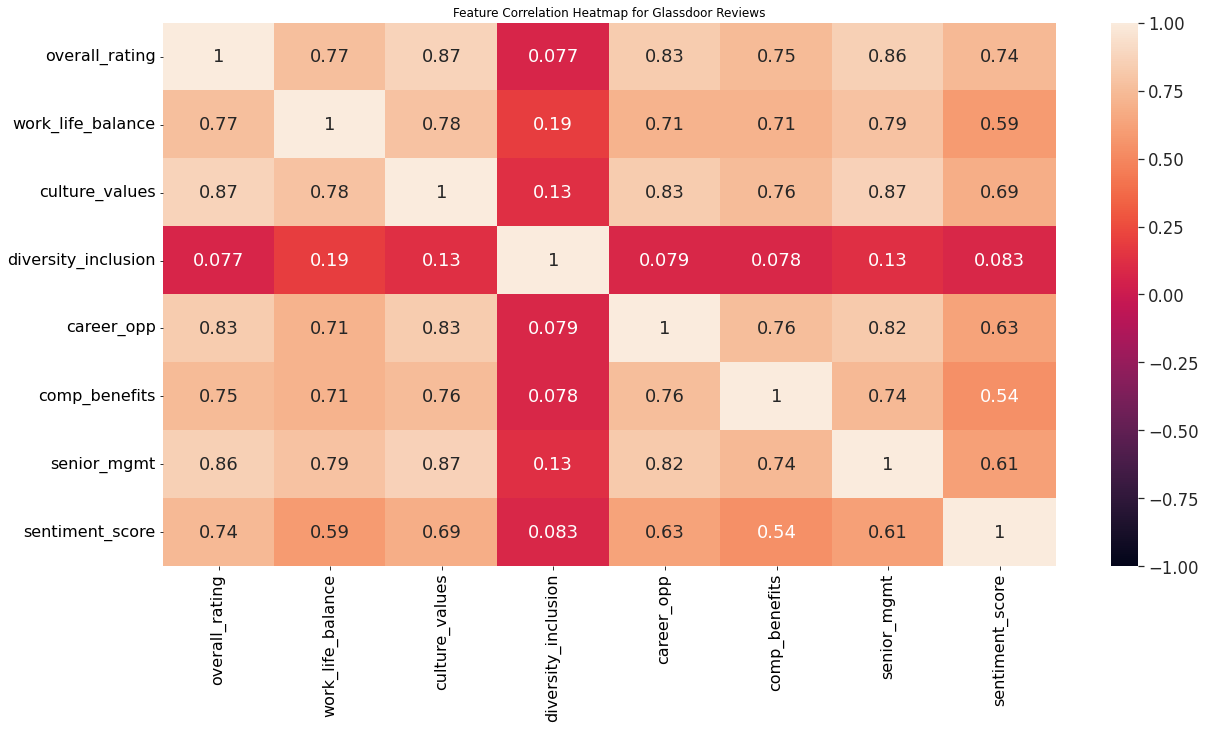

In [ ]:
df_glassdoor_corr = df_glassdoor_monthly[['overall_rating', 'work_life_balance', 'culture_values', 'diversity_inclusion', 'career_opp', 'comp_benefits', 'senior_mgmt', 'sentiment_score']].corr()
plt.figure(figsize = (20, 10))
plt.title("Feature Correlation Heatmap for Glassdoor Reviews")
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
sns.set(font_scale = 1.5)
heatmap = sns.heatmap(df_glassdoor_corr, vmin = -1, vmax = 1, annot = True)

We can see in the heatmap above how each rating is correlated with the others, and we can also visualize the relationship between people's ratings for each aspect of their job and the sentiment of their headline. We can see that the sentiment score of the headline is most closely correlated with the person's overall rating, and as far as particular attributes, it is most closely correlated with culture and values. This indicates that people's overall sentiments about their job is more affected by their impressions of the company's culture than work-life balance, diversity and inclusion, career opportunities, compensation and benefits, and senior management.

However, even so, there is not a standout strong correlation between sentiment and any of the features. This may be due to the lack of flexibility when it comes to numerical ratings compared to the nuances that people are able to communicate through a headline.

In [ ]:
import plotly.express as px

df_glassdoor_features = df_glassdoor_monthly[['overall_rating', 'work_life_balance', 'culture_values', 'diversity_inclusion', 'career_opp', 'comp_benefits', 'senior_mgmt', 'sentiment_score']]
fig = px.scatter_matrix(df_glassdoor_features, width = 1500, height = 1500)
fig.show()


The matrix above shows the relationships between each feature in a scatter plot. Like the heatmap, this also shows that there is not much to say about a significant correlation between features, as each scatter plot seems to behave relatively similarly.

In [ ]:
df_glass_unemp.columns

Index(['index', 'region', 'month', 'year', 'overall_rating',
       'work_life_balance', 'culture_values', 'diversity_inclusion',
       'career_opp', 'comp_benefits', 'senior_mgmt', 'sentiment_score',
       'Region', 'Quarterly Change', 'Unemployment Rate', 'Date'],
      dtype='object')

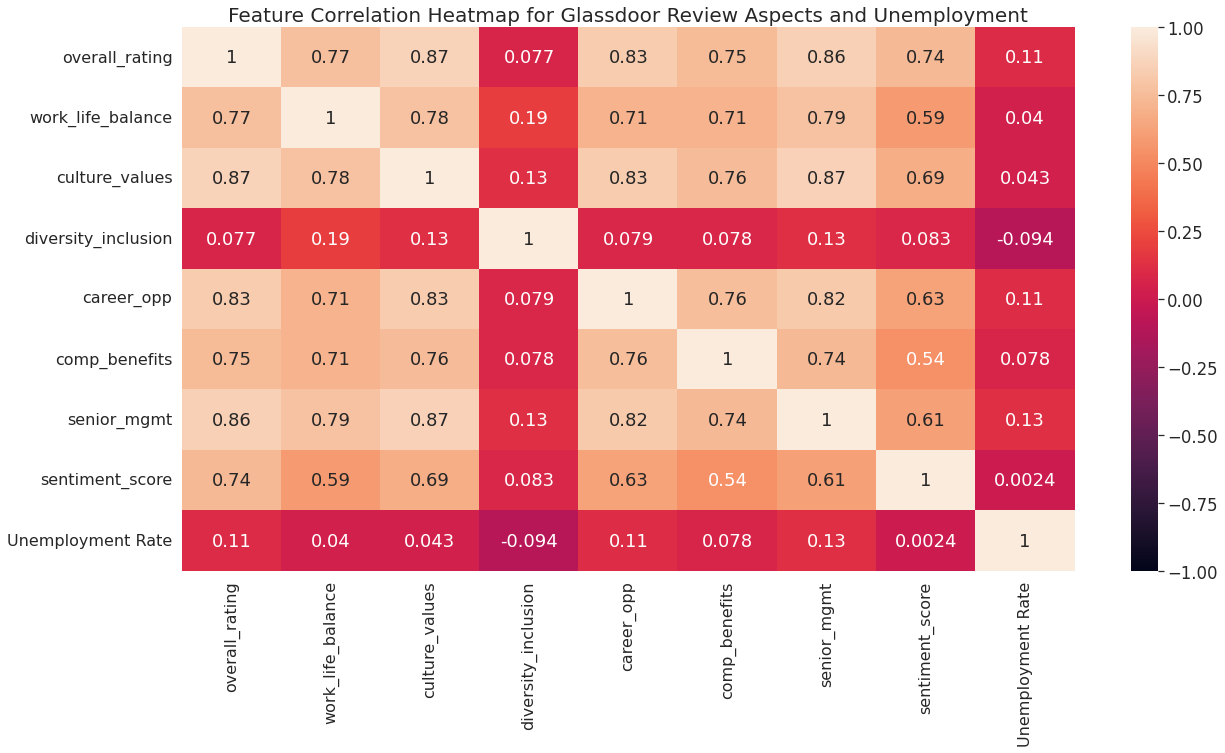

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max = MinMaxScaler()

df_unemp = df_glass_unemp[['overall_rating', 'work_life_balance', 'culture_values', 'diversity_inclusion', 'career_opp', 'comp_benefits', 'senior_mgmt', 'sentiment_score', 'Unemployment Rate']]
min_max.fit(df_unemp)
scaled = min_max.fit_transform(df_unemp)
scaled_unemp = pd.DataFrame(scaled, columns = df_unemp.columns)

df_unemp_corr = scaled_unemp.corr()
plt.figure(figsize = (20, 10))
plt.title("Feature Correlation Heatmap for Glassdoor Review Aspects and Unemployment", fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
sns.set(font_scale = 1.5)
heatmap = sns.heatmap(df_unemp_corr, vmin = -1, vmax = 1, annot = True)

This heatmap includes the same features as the one above, with unemployment rate added, grouped by month and year. There does not seem to be any correlation between ratings and unemployment rate, so we would be interested to see if there is any correlation with region.

In [ ]:
df_unemp = df_unemp.dropna()
features = df_unemp.drop(columns = ['Unemployment Rate'])
labels = df_unemp[['Unemployment Rate']]
threshold = (df_unemp['Unemployment Rate'].max() + df_unemp['Unemployment Rate'].min()) / 2
labels['Unemployment Rate'] = labels['Unemployment Rate'].apply(lambda x: 1 if x >= threshold else 0)
labels = labels['Unemployment Rate']

x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state = 42, test_size = 0.20)


<ipython-input-76-cc60c06b6b21>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_scaled = scaler.fit_transform(x_train)
test_scaled = scaler.transform(x_test)

pca = PCA()
train_pca = pca.fit_transform(train_scaled)

explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = np.cumsum(explained_variance_ratios)

Here we perform PCA to prepare for a logistic regression using ratings to predict unemployment rate for a particular month and year.

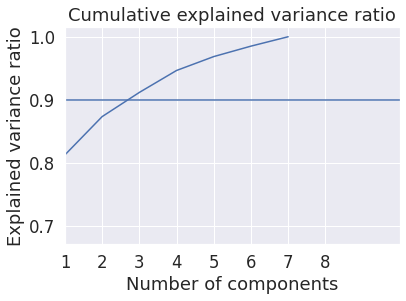

In [ ]:
plt.plot(cum_evr)
plt.xticks(range(1, 9, 1))
plt.xlim(1, 10)

plt.title('Cumulative explained variance ratio')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.axhline(y = 0.9, color = 'b', linestyle = '-')

We calculate the cumulative explained variance ratio in order to determine the number of components we want to use for the logistic regression.

In [ ]:
pca = PCA(n_components = 3)
train_pca = pca.fit_transform(train_scaled, y_train)
x_test_pca = pca.transform(test_scaled)

In [ ]:
logreg = LogisticRegression()
logreg = logreg.fit(train_pca, y_train)
y_pred = logreg.predict(x_test_pca)
accuracy = logreg.score(x_test_pca, y_test)
accuracy

0.7676767676767676

The logistic regression for predicting unemployment rate from ratings has a score of 77%, showing that ratings may be a pretty good indicator of unemployment rate.

## 2.4 How do reviews correlate with recommendations

Now let's see if whether or not people recommend their job can be discerned from the ratings.

In [ ]:
df_glassdoor_with_regions.columns

Index(['firm', 'date_review', 'job_title', 'current', 'location',
       'overall_rating', 'work_life_balance', 'culture_values',
       'diversity_inclusion', 'career_opp', 'comp_benefits', 'senior_mgmt',
       'recommend', 'ceo_approv', 'outlook', 'headline', 'pros', 'cons',
       'city', 'region'],
      dtype='object')

In [ ]:
!pip install pyspark


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 199 kB 48.6 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=4b22f7f009798277510f5f5917528c60240d87180773a7019b8e12e26ac2001e
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

In [ ]:
df_glassdoor.columns

Index(['firm', 'date_review', 'job_title', 'current', 'location',
       'overall_rating', 'work_life_balance', 'culture_values',
       'diversity_inclusion', 'career_opp', 'comp_benefits', 'senior_mgmt',
       'recommend', 'ceo_approv', 'outlook', 'headline', 'pros', 'cons'],
      dtype='object')

In [ ]:
!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  comerr-dev krb5-multidev libgssrpc4 libkadm5clnt-mit11 libkadm5srv-mit11
  libkdb5-9
Suggested packages:
  doc-base krb5-doc krb5-user
The following NEW packages will be installed:
  comerr-dev krb5-multidev libgssrpc4 libkadm5clnt-mit11 libkadm5srv-mit11
  libkdb5-9 libkrb5-dev
0 upgraded, 7 newly installed, 0 to remove and 20 not upgraded.
Need to get 349 kB of archives.
After this operation, 1,992 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libgssrpc4 amd64 1.16-2ubuntu0.2 [54.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libkdb5-9 amd64 1.16-2ubuntu0.2 [37.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('final').getOrCreate()

In [ ]:
%load_ext sparkmagic.magics

In [ ]:
# Graph section
import networkx as nx
# SQLite RDBMS
import sqlite3
# Parallel processing
# import swifter
import pandas as pd
# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ['SPARK_HOME'] = '/content/spark-3.1.2-bin-hadoop3.2'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [ ]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

In [ ]:
schema = StructType([
    StructField('overall_rating', IntegerType(), True),
    StructField('work_life_balance', FloatType(), True),
    StructField('culture_values', FloatType(), True),
    StructField('diversity_inclusion', FloatType(), True),
    StructField('career_opp', FloatType(), True),
    StructField('comp_benefits', FloatType(), True),
    StructField('senior_mgmt', FloatType(), True),
    StructField('recommend', StringType(), True)
])

In [ ]:
# Create Spark DataFrame

recommend = df_glassdoor_with_regions[['overall_rating', 'work_life_balance', 'culture_values',
       'diversity_inclusion', 'career_opp', 'comp_benefits', 'senior_mgmt',
       'recommend']]
sdf_glassdoor = spark.createDataFrame(recommend, schema = schema)

In [ ]:
# Create VectorAssembler and StringIndexer object

features = list(set(sdf_glassdoor.columns) - set(['recommend']))

assembler = VectorAssembler(inputCols = features, outputCol = 'features')
indexer = StringIndexer(inputCol = 'recommend', outputCol = 'label').setHandleInvalid('skip')

In [ ]:
# Create pipeline

pipeline = Pipeline(stages = [assembler, indexer])
modified_sdf = pipeline.fit(sdf_glassdoor).transform(sdf_glassdoor)

In [ ]:
# 80/20 test split

train_sdf, test_sdf = modified_sdf.randomSplit([0.8, 0.2], seed = 42)

In [ ]:
# Create decision tree

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', seed = 42, maxDepth = 7)
dt = dt.fit(train_sdf)

In [ ]:
# Get predictions from tree

train_pred = dt.transform(train_sdf)
test_pred = dt.transform(test_sdf)

In [ ]:
train = train_pred.select(train_pred['prediction'], train_pred['label'])
test = test_pred.select(test_pred['prediction'], test_pred['label'])
train_metrics = MulticlassMetrics(train.rdd)
test_metrics = MulticlassMetrics(test.rdd)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



In [ ]:
modified_sdf.show()

+--------------+-----------------+--------------+-------------------+----------+-------------+-----------+---------+--------------------+-----+
|overall_rating|work_life_balance|culture_values|diversity_inclusion|career_opp|comp_benefits|senior_mgmt|recommend|            features|label|
+--------------+-----------------+--------------+-------------------+----------+-------------+-----------+---------+--------------------+-----+
|             1|              2.0|           1.0|          3.8894048|       1.0|          1.0|        1.0|        x|[3.88940477371215...|  2.0|
|             1|              3.0|           1.0|          3.8894048|       1.0|          1.0|        1.0|        x|[3.88940477371215...|  2.0|
|             4|              4.0|           5.0|          3.8894048|       3.0|          3.0|        5.0|        v|[3.88940477371215...|  0.0|
|             5|              5.0|           5.0|          3.8894048|       5.0|          4.0|        5.0|        v|[3.88940477371215...

From visualizing the modified sdf, we can see: the label 2.0 is associated with recommendation "x", the label 1.0 is associated with recommendation "o", and the label 0.0 is associated with recommendation "v".

In [ ]:
# Calculate accuracies for each recommendation label

test_accuracies = []
train_accuracies = []

train_accuracies.append(train_metrics.precision(0.0))
train_accuracies.append(train_metrics.precision(1.0))
train_accuracies.append(train_metrics.precision(2.0))

test_accuracies.append(test_metrics.precision(0.0))
test_accuracies.append(test_metrics.precision(1.0))
test_accuracies.append(test_metrics.precision(2.0))

<function matplotlib.pyplot.show(*args, **kw)>

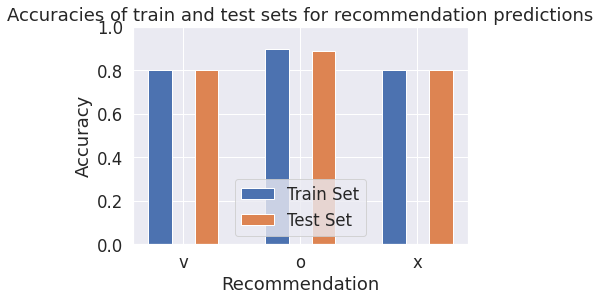

In [ ]:
# Plot accuracies

x = ['v', 'o', 'x']

x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, train_accuracies, 0.2, label = 'Train Set')
plt.bar(x_axis + 0.2, test_accuracies, 0.2, label = 'Test Set')
plt.ylim(0.0, 1.0)

plt.xticks(x_axis, x)
plt.xlabel('Recommendation')
plt.ylabel('Accuracy')
plt.title('Accuracies of train and test sets for recommendation predictions')
plt.legend()
plt.show

We can see that our prediction accuracy is very high! Let's see if we can make it higher by doing the same process with a random forest.

In [ ]:
# Create Random Forest

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed = 42, maxDepth = 7)
rf = rf.fit(train_sdf)

In [ ]:
# Get predictions from forest

train_pred = rf.transform(train_sdf)
test_pred = rf.transform(test_sdf)

In [ ]:
train = train_pred.select(train_pred['prediction'], train_pred['label'])
test = test_pred.select(test_pred['prediction'], test_pred['label'])
train_metrics = MulticlassMetrics(train.rdd)
test_metrics = MulticlassMetrics(test.rdd)

# Get accuracies for predictions
test_accuracies = []
train_accuracies = []

train_accuracies.append(train_metrics.precision(0.0))
train_accuracies.append(train_metrics.precision(1.0))
train_accuracies.append(train_metrics.precision(2.0))

test_accuracies.append(test_metrics.precision(0.0))
test_accuracies.append(test_metrics.precision(1.0))
test_accuracies.append(test_metrics.precision(2.0))

<function matplotlib.pyplot.show(*args, **kw)>

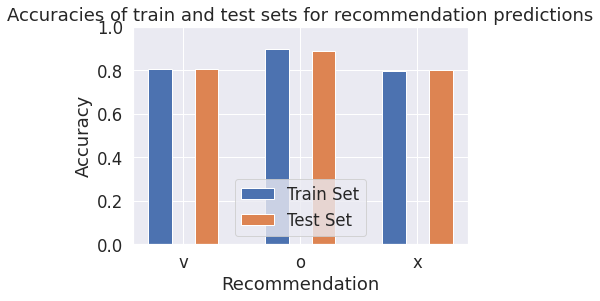

In [ ]:
# Plot accuracies for each recommendation label

x = ['v', 'o', 'x']

x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, train_accuracies, 0.2, label = 'Train Set')
plt.bar(x_axis + 0.2, test_accuracies, 0.2, label = 'Test Set')
plt.ylim(0.0, 1.0)

plt.xticks(x_axis, x)
plt.xlabel('Recommendation')
plt.ylabel('Accuracy')
plt.title('Accuracies of train and test sets for recommendation predictions')
plt.legend()
plt.show

The accuracies for each recommendation did not change, show that !!ADD SOMETHING HERE IDK WHAT IT SHOWS!!

Now let's do the same with factoring in unemployment!

In [ ]:
df_glassdoor_overall['recommend'].unique()

array(['x', 'v', 'o'], dtype=object)

In [ ]:
schema = StructType([
    StructField('overall_rating', IntegerType(), True),
    StructField('work_life_balance', FloatType(), True),
    StructField('culture_values', FloatType(), True),
    StructField('diversity_inclusion', FloatType(), True),
    StructField('career_opp', FloatType(), True),
    StructField('comp_benefits', FloatType(), True),
    StructField('senior_mgmt', FloatType(), True),
    StructField('u_rate', FloatType(), True),
    StructField('recommend_o', IntegerType(), True),
    StructField('recommend_v', IntegerType(), True),
    StructField('recommend_x', IntegerType(), True)
])

In [ ]:
from math import floor
df_recommend_onehot = pd.get_dummies(df_glassdoor_overall[['overall_rating', 'work_life_balance', 'culture_values',
       'diversity_inclusion', 'career_opp', 'comp_benefits', 'senior_mgmt',
       'recommend', 'u_rate']], columns = ['recommend'])

df_recommend_onehot['u_rate'] = df_recommend_onehot['u_rate'].apply(lambda x: float(floor(x)))

In [ ]:
# Create Spark DataFrame

sdf_unemp = spark.createDataFrame(df_recommend_onehot, schema = schema)

In [ ]:
# Create VectorAssembler
features = list(set(sdf_unemp.columns) - set(['u_rate']))
assembler = VectorAssembler(inputCols = features, outputCol = 'features')

In [ ]:
# Create Pipeline

pipeline = Pipeline(stages = [assembler])
modified_sdf = pipeline.fit(sdf_unemp).transform(sdf_unemp)

In [ ]:
# Test split

train_sdf, test_sdf = modified_sdf.randomSplit([0.8, 0.2], seed = 42)

In [ ]:
# Create Decision Tree

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'u_rate', seed = 42, maxDepth = 7)
dt = dt.fit(train_sdf)

In [ ]:
# Get predictions from tree

train_pred = dt.transform(train_sdf)
test_pred = dt.transform(test_sdf)

In [ ]:
train = train_pred.select(train_pred['prediction'], train_pred['u_rate'])
test = test_pred.select(test_pred['prediction'], test_pred['u_rate'])
train_metrics = MulticlassMetrics(train.rdd)
test_metrics = MulticlassMetrics(test.rdd)

In [ ]:
# Calculate accuracies for each unemployment rate label

test_accuracies = []
train_accuracies = []

i = 0.0
while (i < 8.0):
    if (i in df_recommend_onehot['u_rate'].unique()):
      train_accuracies.append(train_metrics.precision(i))
      test_accuracies.append(test_metrics.precision(i))
    else:
      train_accuracies.append(0)
      test_accuracies.append(0)
    i += 1.0

<function matplotlib.pyplot.show(*args, **kw)>

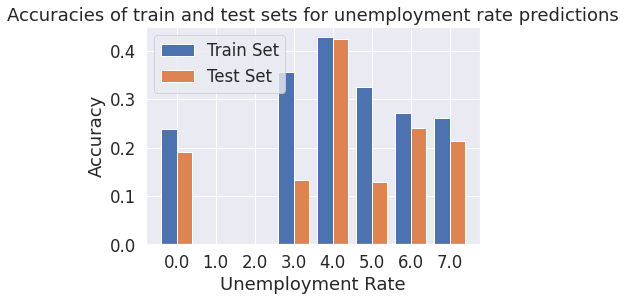

In [ ]:
# Plot accuracies

x = [float(x) for x in range(8)]

x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, train_accuracies, 0.4, label = 'Train Set')
plt.bar(x_axis + 0.2, test_accuracies, 0.4, label = 'Test Set')

plt.xticks(x_axis, x)
plt.xlabel('Unemployment Rate')
plt.ylabel('Accuracy')
plt.title('Accuracies of train and test sets for unemployment rate predictions')
plt.legend()
plt.show

We can observe a few things: Firstly, none of our data has an unemployment rate between 1 and 2. We can also see that some overfitting has occured. For unemployment rates between 2 and 3, and rates above 7, the test set accuracy is 0. This shows that data with these unemployment rates did not make it into the test set. While we could make the test set smaller in hopes that some data in these categories would make it, but we can already see that accuracies are generally low across the board, indicating that ratings may not be a good predictor for unemployment rate.

Let's try to improve predictions of unemployment using a random forest instead of a decision tree.

##2.4 Decision Trees (Daniel)
Use decision trees to help us predict whether or not a review recommends a particular option

###2.4.1 Preprocessing

In [ ]:
df_glassdoor_decision = df_glassdoor_overall.drop(columns = ['firm', 'job_title', 'city', 'headline', 'pros', 'cons', 'sentiment'])
df_glassdoor_decision['is_current'] = df_glassdoor_overall['current'].apply(lambda x: 1 if x.split(' ')[0] == 'Current' else 0)
df_glassdoor_decision['month'] = pd.DatetimeIndex(df_glassdoor_decision['date_review']).month
df_glassdoor_decision['year'] = pd.DatetimeIndex(df_glassdoor_decision['date_review']).year
df_glassdoor_decision = df_glassdoor_decision.drop(columns = ['date_review', 'current'])

In [ ]:
df_glassdoor_decision['region'] = df_glassdoor_decision['region'].apply(lambda x: x.replace(" ", "_"))
df_glassdoor_decision = pd.get_dummies(data = df_glassdoor_decision, columns = ['ceo_approv', 'outlook', 'region'])

In [ ]:
df_glassdoor_decision = df_glassdoor_decision.astype({"overall_rating": float})

In [ ]:
#v - Positive, r - Mild, x - Negative, o - No opinion
df_glassdoor_recommend = df_glassdoor_decision[df_glassdoor_decision['recommend'] != 'o'].drop(columns=['overall_rating'])
print(df_glassdoor_recommend[df_glassdoor_recommend['recommend'] == 'r'])
df_glassdoor_recommend['recommend'] = df_glassdoor_recommend['recommend'].apply(lambda x: 1.0 if x == 'v' else 0.0)
df_glassdoor_rating = df_glassdoor_decision.drop(columns=['recommend'])

Empty DataFrame
Columns: [work_life_balance, culture_values, diversity_inclusion, career_opp, comp_benefits, senior_mgmt, recommend, sentiment_score, u_rate, month, year, is_current, ceo_approv_o, ceo_approv_r, ceo_approv_v, ceo_approv_x, outlook_o, outlook_r, outlook_v, outlook_x, region_east, region_east_midlands, region_london, region_north_east, region_north_west, region_northern_ireland, region_scotland, region_south_east, region_south_west, region_wales, region_west_midlands, region_yorkshire_and_the_humber]
Index: []

[0 rows x 32 columns]


In [ ]:
features_rec = df_glassdoor_recommend.drop(columns=['recommend'])
# features_rec_unemp = df_glassdoor_recommend.drop(columns=['recommend'])
rec = df_glassdoor_recommend['recommend']
features_rat = df_glassdoor_rating.drop(columns=['overall_rating'])
# features_rat_unemp = df_glassdoor_rating.drop(columns=['overall_rating'])
ratings = df_glassdoor_rating['overall_rating']

In [ ]:
from sklearn.model_selection import train_test_split
seed = 42
x_train_rating, x_test_rating, y_train_rating, y_test_rating = train_test_split(features_rat, ratings, random_state=seed, test_size = 0.2, train_size=0.8)
x_train_rec, x_test_rec, y_train_rec, y_test_rec = train_test_split(features_rec, rec, random_state=seed, test_size = 0.2, train_size=0.8)

x_train_rat_unemp, x_test_rat_unemp = x_train_rating, x_test_rating
x_train_rec_unemp, x_test_rec_unemp = x_train_rec, x_test_rec

x_train_rating = x_train_rating.drop(columns = ['u_rate'])
x_test_rating = x_test_rating.drop(columns = ['u_rate'])
x_train_rec = x_train_rec.drop(columns = ['u_rate'])
x_test_rec = x_test_rec.drop(columns = ['u_rate'])

### 2.4.1 PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler_rat = StandardScaler()
x_train_rat_sc = scaler_rat.fit_transform(x_train_rating)
x_test_rat_sc = scaler_rat.transform(x_test_rating)

scaler_rec = StandardScaler()
x_train_rec_sc = scaler_rec.fit_transform(x_train_rec)
x_test_rec_sc = scaler_rec.transform(x_test_rec)

([<matplotlib.axis.XTick at 0x7f015a551bb0>,
 <a list of 15 Text major ticklabel objects>)

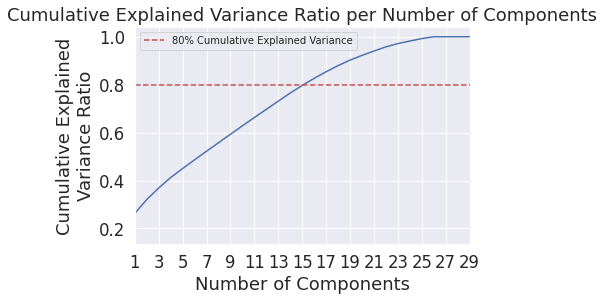

In [ ]:
from sklearn.decomposition import PCA
pca_rat = PCA()
pca_rat = pca_rat.fit(x_train_rat_sc, y_train_rating)
explained_variance_ratios_rat = pca_rat.explained_variance_ratio_
cum_evr_rat = np.cumsum(explained_variance_ratios_rat)
# Plot (1 point for correct shape)
plt.title('Cumulative Explained Variance Ratio per Number of Components')
plt.plot(cum_evr_rat)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained\nVariance Ratio')
plt.xlim(1,23)
line = plt.axhline(y = 0.8, color = 'r', linestyle = '--')
plt.legend([line], ['80% Cumulative Explained Variance'], prop={'size':10})
plt.xticks(range(1,31,2))

In [ ]:
pca_rat = PCA(n_components=17)

x_train_rat_pca = pca_rat.fit_transform(x_train_rat_sc, y_train_rating)
x_test_rat_pca = pca_rat.transform(x_test_rat_sc)


([<matplotlib.axis.XTick at 0x7f015a40c4c0>,
 <a list of 15 Text major ticklabel objects>)

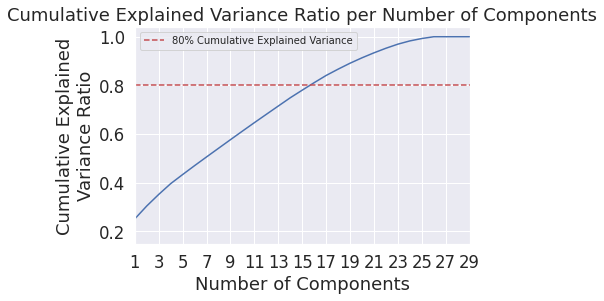

In [ ]:
pca_rec = PCA()
pca_rec = pca_rec.fit(x_train_rec_sc, y_train_rec)
explained_variance_ratios_rec = pca_rec.explained_variance_ratio_
cum_evr_rec = np.cumsum(explained_variance_ratios_rec)
# Plot (1 point for correct shape)
plt.title('Cumulative Explained Variance Ratio per Number of Components')
plt.plot(cum_evr_rec)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained\nVariance Ratio')
plt.xlim(1,23)
line = plt.axhline(y = 0.8, color = 'r', linestyle = '--')
plt.legend([line], ['80% Cumulative Explained Variance'], prop={'size':10})
plt.xticks(range(1,31,2))

In [ ]:
pca_rec = PCA(n_components=17)

x_train_rec_pca = pca_rec.fit_transform(x_train_rec_sc, y_train_rec)
x_test_rec_pca = pca_rec.transform(x_test_rec_sc)

### 2.4.3 Decision Trees Classification

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import accuracy_score
import graphviz

####2.4.3.1 Ratings Decision Tree

Baseline (without unemployment data)

In [ ]:
dt_rating = DecisionTreeClassifier(max_depth=15)
dt_rating = dt_rating.fit(x_train_rating, y_train_rating)

train_pred_dt_rat = dt_rating.predict(x_train_rating)
test_pred_dt_rat = dt_rating.predict(x_test_rating)

In [ ]:
train_acc_rat = accuracy_score(train_pred_dt_rat, y_train_rating)
test_acc_rat = accuracy_score(test_pred_dt_rat, y_test_rating)
print("training accuracy: ", train_acc_rat)
print("testing accuracy: ", test_acc_rat)

training accuracy:  0.7307152547130094
testing accuracy:  0.5984001496935959


With PCA

In [ ]:
dt_rating_pca = DecisionTreeClassifier(max_depth=15)
dt_rating_pca = dt_rating_pca.fit(x_train_rat_pca, y_train_rating)

train_pred_dt_rat_pca = dt_rating_pca.predict(x_train_rat_pca)
test_pred_dt_rat_pca = dt_rating_pca.predict(x_test_rat_pca)

In [ ]:
train_acc_rat_pca = accuracy_score(train_pred_dt_rat_pca, y_train_rating)
test_acc_rat_pca = accuracy_score(test_pred_dt_rat_pca, y_test_rating)
print("training accuracy: ", train_acc_rat_pca)
print("testing accuracy: ", test_acc_rat_pca)

training accuracy:  0.7332647237685362
testing accuracy:  0.5706600551995135


In [ ]:
# dot_data = export_graphviz(dt_rating_pca, out_file=None, feature_names=['f{i}' for i in range(1,18)], class_names=['1','2','3','4','5'], filled=True, rounded=True,  special_characters=True)
# graph = graphviz.Source(dot_data)
# graph.render('Ratings')

With unemployment data

In [ ]:
dt_rating_unemp = DecisionTreeClassifier(max_depth=15)
dt_rating_unemp = dt_rating_unemp.fit(x_train_rat_unemp, y_train_rating)

train_pred_dt_rat_unemp = dt_rating_unemp.predict(x_train_rat_unemp)
test_pred_dt_rat_unemp = dt_rating_unemp.predict(x_test_rat_unemp)

In [ ]:
train_acc_rat_unemp = accuracy_score(train_pred_dt_rat_unemp, y_train_rating)
test_acc_rat_unemp = accuracy_score(test_pred_dt_rat_unemp, y_test_rating)
print("training accuracy: ", train_acc_rat_unemp)
print("testing accuracy: ", test_acc_rat_unemp)

training accuracy:  0.7354048743977172
testing accuracy:  0.5968096552369369


#### 2.4.3.2 Recommendation Decision Tree

Baseline (no unemployment data)

In [ ]:
dt_rec = DecisionTreeClassifier(max_depth=15)
dt_rec = dt_rec.fit(x_train_rec, y_train_rec)

train_pred_dt_rec = dt_rec.predict(x_train_rec)
test_pred_dt_rec = dt_rec.predict(x_test_rec)

In [ ]:
train_acc_rec = accuracy_score(train_pred_dt_rec, y_train_rec)
test_acc_rec = accuracy_score(test_pred_dt_rec, y_test_rec)
print("training accuracy: ", train_acc_rec)
print("testing accuracy: ", test_acc_rec)

training accuracy:  0.9545199501246883
testing accuracy:  0.8796134663341646


With PCA

In [ ]:
dt_rec_pca = DecisionTreeClassifier(max_depth=15)
dt_rec_pca = dt_rec_pca.fit(x_train_rec_pca, y_train_rec)

train_pred_dt_rec_pca = dt_rec_pca.predict(x_train_rec_pca)
test_pred_dt_rec_pca = dt_rec_pca.predict(x_test_rec_pca)

In [ ]:
train_acc_rec_pca = accuracy_score(train_pred_dt_rec_pca, y_train_rec)
test_acc_rec_pca = accuracy_score(test_pred_dt_rec_pca, y_test_rec)
print("training accuracy: ", train_acc_rec_pca)
print("testing accuracy: ", test_acc_rec_pca)

training accuracy:  0.9483478802992519
testing accuracy:  0.8771197007481297


In [ ]:
# dot_data = export_graphviz(dt_rec_pca, out_file=None, feature_names=['f{i}' for i in range(1,18)], class_names=['1','2','3','4','5'], filled=True, rounded=True,  special_characters=True)
# graph = graphviz.Source(dot_data)
# graph.render('Recommendation')

With unemployment data

In [ ]:
dt_rec_unemp = DecisionTreeClassifier(max_depth=15)
dt_rec_unemp = dt_rec_unemp.fit(x_train_rec_unemp, y_train_rec)

train_pred_dt_rec_unemp = dt_rec_unemp.predict(x_train_rec_unemp)
test_pred_dt_rec_unemp = dt_rec_unemp.predict(x_test_rec_unemp)

In [ ]:
train_acc_rec_unemp = accuracy_score(train_pred_dt_rec_unemp, y_train_rec)
test_acc_rec_unemp = accuracy_score(test_pred_dt_rec_unemp, y_test_rec)
print("training accuracy: ", train_acc_rec_unemp)
print("testing accuracy: ", test_acc_rec_unemp)

training accuracy:  0.9571228179551122
testing accuracy:  0.8726309226932668


### 2.4.4 Random Forest Classification

We did this in Spark to show that we can

In [ ]:
!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libkrb5-dev is already the newest version (1.16-2ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
--2022-12-12 19:40:04--  https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
Resolving downloads.apache.org (downloads.apache.org)... 88.99.95.219, 135.181.214.104, 2a01:4f8:10a:201a::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|88.99.95.219|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-12-12 19:40:04 ERROR 404: Not Found.

tar: spark-3.1.2-bin-hadoop3.2.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: http

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('project_final').getOrCreate()

In [ ]:
%load_ext sparkmagic.magics

The sparkmagic.magics extension is already loaded. To reload it, use:
  %reload_ext sparkmagic.magics


In [ ]:
## RUN BUT DO NOT MODIFY ANY OF THIS CODE

# Graph section
import networkx as nx
# SQLite RDBMS
import sqlite3
# Parallel processing
# import swifter
import pandas as pd
# NoSQL DB
from pymongo import MongoClient
from pymongo.errors import DuplicateKeyError, OperationFailure

import os
os.environ['SPARK_HOME'] = '/content/spark-3.1.2-bin-hadoop3.2'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [ ]:
## RUN BUT DO NOT MODIFY ANY OF THIS CODE
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

In [ ]:
rec_sdf = spark.createDataFrame(df_glassdoor_recommend)
rat_sdf = spark.createDataFrame(df_glassdoor_rating)

In [ ]:
rec_features_cols = [_ for _ in features_rec.columns]
rat_features_cols = [_ for _ in features_rat.columns]

In [ ]:
from pyspark.ml.feature import VectorAssembler
rec_assembler = VectorAssembler(inputCols = rec_features_cols, outputCol = "features")
rat_assembler = VectorAssembler(inputCols = rat_features_cols, outputCol = "features")

In [ ]:
from pyspark.ml import Pipeline

rec_pipe  = Pipeline(stages = [rec_assembler])
mod_rec_sdf = rec_pipe.fit(rec_sdf).transform(rec_sdf)
rec_train_sdf, rec_test_sdf = mod_rec_sdf.randomSplit([0.8, 0.2], seed=seed)

rat_pipe  = Pipeline(stages = [rat_assembler])
mod_rat_sdf = rat_pipe.fit(rat_sdf).transform(rat_sdf)
rat_train_sdf, rat_test_sdf = mod_rat_sdf.randomSplit([0.8, 0.2], seed=seed)

#### 2.4.4.2 Ratings

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rat_rf = RandomForestClassifier(featuresCol = "features",
                            labelCol = "overall_rating",
                            maxDepth = 15,
                            seed=seed)
rat_rf = rat_rf.fit(rat_train_sdf)

rat_train_pred = rat_rf.transform(rat_train_sdf)
rat_test_pred = rat_rf.transform(rat_test_sdf)

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

rat_metrics_train = MulticlassMetrics(rat_train_pred[['prediction', 'overall_rating']].rdd)
rat_metrics_test = MulticlassMetrics(rat_test_pred[['prediction', 'overall_rating']].rdd)

rat_rf_train_cm = rat_metrics_train.confusionMatrix().toArray()
rat_rf_test_cm = rat_metrics_test.confusionMatrix().toArray()

# TO-DO: Evaluate predictions using accuracy for both train and test
#        and call these `rf_train_accuracy` and `rf_test_accuracy` respectively
rat_rf_train_accuracy = rat_metrics_train.accuracy
rat_rf_test_accuracy = rat_metrics_test.accuracy
# rat_train_pred.printSchema()

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



In [ ]:
print("training accuracy: ", rat_rf_train_accuracy)
print("testing accuracy: ", rat_rf_test_accuracy)

training accuracy:  0.7465078493027388
testing accuracy:  0.629968128983877


Below is the sklearn option

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Instantiate RF with some chosen hyperparameters
rf_rating = RandomForestClassifier()

# Fit to original data (why doesn't this have to be scaled?)
rf_rating.fit(x_train_rating, y_train_rating)

# Predict on training and testing sets
train_pred_rf_rat = rf_rating.predict(x_train_rating)
test_pred_rf_rat = rf_rating.predict(x_test_rating)

In [ ]:
print("training accuracy: ", rf_rating.score(x_train_rating, y_train_rating))
print("testing accuracy: ", rf_rating.score(x_test_rating, y_test_rating))

training accuracy:  0.940192730504748
testing accuracy:  0.6299293633344248


#### 2.4.4.2 Recommendations

In [ ]:
rec_rf = RandomForestClassifier(featuresCol = "features",
                            labelCol = "recommend",
                            maxDepth = 15,
                            seed=seed)
rec_rf = rec_rf.fit(rec_train_sdf)

rec_train_pred = rec_rf.transform(rec_train_sdf)
rec_test_pred = rec_rf.transform(rec_test_sdf)

In [ ]:

rec_metrics_train = MulticlassMetrics(rec_train_pred[['prediction', 'recommend']].rdd)
rec_metrics_test = MulticlassMetrics(rec_test_pred[['prediction', 'recommend']].rdd)

rec_rf_train_cm = rec_metrics_train.confusionMatrix().toArray()
rec_rf_test_cm = rec_metrics_test.confusionMatrix().toArray()

# TO-DO: Evaluate predictions using accuracy for both train and test
#        and call these `rf_train_accuracy` and `rf_test_accuracy` respectively
rec_rf_train_accuracy = rec_metrics_train.accuracy
rec_rf_test_accuracy = rec_metrics_test.accuracy
# rat_train_pred.printSchema()

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



In [ ]:
print("training accuracy: ", rec_rf_train_accuracy)
print("testing accuracy: ", rec_rf_test_accuracy)

training accuracy:  0.9491451595339214
testing accuracy:  0.9004962623280357


##2.5 Time Series

In [ ]:
lockdown_start = pd.Timestamp(year=2020, month=3, day=20)
df_glassdoor_precovid = df_glassdoor_overall[df_glassdoor_overall['date_review'] < lockdown_start]
df_glassdoor_covid = df_glassdoor_overall[df_glassdoor_overall['date_review'] >= lockdown_start]
df_glassdoor_groups_pc = df_glassdoor_precovid[['region', 'date_review', 'overall_rating']].groupby(by=['region'])
df_glassdoor_groups_cv = df_glassdoor_covid[['region', 'date_review', 'overall_rating']].groupby(by=['region'])

In [ ]:
pc_graph = pd.DataFrame()
for name, group in df_glassdoor_groups_pc:
  vals = group.drop(columns=['region'])
  vals = vals.groupby(by='date_review').mean()
  vals = vals['overall_rating'].resample('M').mean()
  # print(type(vals))
  # print((name))
  # print(vals)
  pc_graph[name] = vals


east
date_review
2018-01-31    3.192611
2018-02-28    3.356857
2018-03-31    3.749405
2018-04-30    3.539333
2018-05-31    3.162401
2018-06-30    3.375776
2018-07-31    3.522222
2018-08-31    3.621333
2018-09-30    3.570370
2018-10-31    3.248148
2018-11-30    3.072222
2018-12-31    3.772000
2019-01-31    3.476389
2019-02-28    3.593056
2019-03-31    3.524471
2019-04-30    3.243959
2019-05-31    3.501217
2019-06-30    3.502822
2019-07-31    3.607307
2019-08-31    3.386692
2019-09-30    3.368552
2019-10-31    3.523614
2019-11-30    3.658730
2019-12-31    3.188095
2020-01-31    3.503853
2020-02-29    3.487125
2020-03-31    3.655208
Freq: M, Name: overall_rating, dtype: float64
east midlands
date_review
2018-01-31    3.656818
2018-02-28    3.755072
2018-03-31    3.342593
2018-04-30    3.495833
2018-05-31    3.737179
2018-06-30    3.871212
2018-07-31    3.575758
2018-08-31    3.653175
2018-09-30    3.258974
2018-10-31    3.679487
2018-11-30    3.583333
2018-12-31    3.935294
2019-01-31    

In [ ]:
c_graph = pd.DataFrame()
for name, group in df_glassdoor_groups_cv:
  # group['month_year'] = group['date_review'].dt.to_period('M')
  # vals = group.drop(columns=['region', 'date_review'])
  # vals = vals.groupby(by='month_year').mean()
  # # print(type(vals))
  # # print((name))
  # # print(vals.values)
  vals = group.drop(columns=['region'])
  vals = vals.groupby(by='date_review').mean()
  vals = vals['overall_rating'].resample('M').mean()
  c_graph[name] = vals

Text(0, 0.5, 'Mean Review Score')

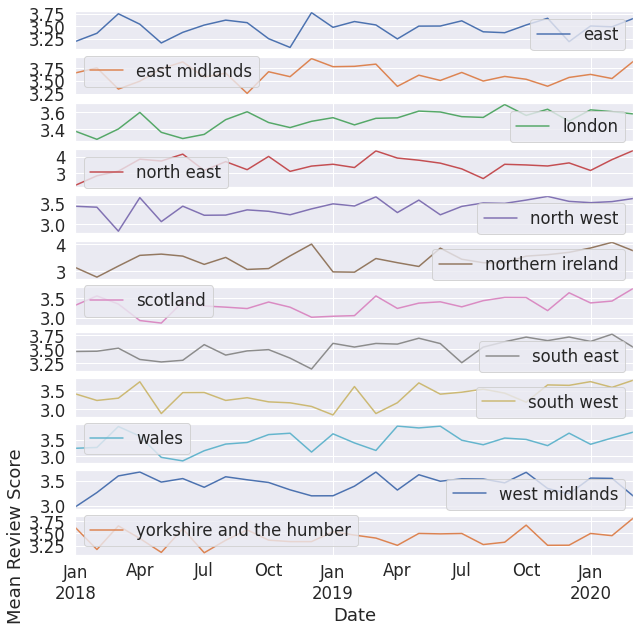

In [ ]:
pc_graph.plot(subplots=True, legend=True)
plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel('Date')
plt.ylabel('Mean Review Score')


Text(0, 0.5, 'Mean Review Score')

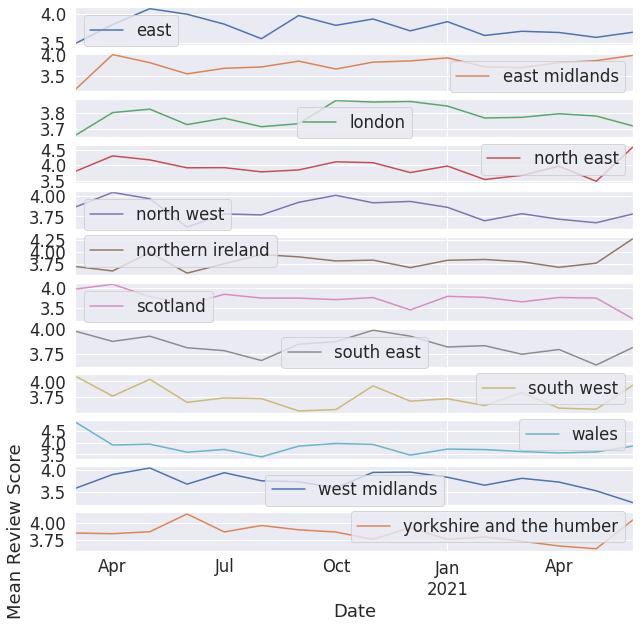

In [ ]:
c_graph.plot(subplots=True, legend=True)
plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel('Date')
plt.ylabel('Mean Review Score')

In [ ]:
# import matplotlib.dates as mdates

# fig = df_glassdoor_timeseries['overall_rating'].plot()
# plt.xlabel('Date')
# plt.ylabel('Mean Review Score')
# # plt.xticks(list(pd.date_range(start=pd.Timestamp(year=2018, month=1, day=1), end=pd.Timestamp(year=2022, month=1, day=1), freq="M")))
# fig.xaxis.set_major_locator(mdates.MonthLocator())
# fig.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
# plt.rcParams["figure.figsize"] = (50,5)
df_glassdoor_covid

,firm,date_review,job_title,current,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,...,pros,cons,city,region,sentiment_score,sentiment,u_rate,month,year,covid_status
8,AFH-Wealth-Management,2020-06-05,Back Office Support,"Current Employee, more than 3 years",2,3.44923,3.554153,3.889405,3.374391,3.383198,...,A growing and profitable company.\r\nFlexible ...,"Autocratic, very much a “my way or the highway...",Bromsgrove,west midlands,-0.0500,negative,4.803,6,2020,Covid
9,AFH-Wealth-Management,2020-06-08,Anonymous Employee,"Former Employee, less than 1 year",1,3.00000,1.000000,3.889405,1.000000,1.000000,...,Working hours \r\nSome of the people you work ...,Supervisor made me very uneasy from the start ...,Bromsgrove,west midlands,-0.2960,negative,4.803,6,2020,Covid
10,AFH-Wealth-Management,2020-10-01,Office Administrator,"Former Employee, more than 3 years",2,1.00000,3.000000,1.000000,1.000000,2.000000,...,"Great people in some places, excellent Christm...","Poor pay, huge gap for pay between senior mana...",Bromsgrove,west midlands,-0.5423,negative,4.626,10,2020,Covid
11,AFH-Wealth-Management,2021-02-05,Quality Control,Former Employee,1,3.00000,1.000000,2.000000,1.000000,1.000000,...,"Majority of the people there are lovely, and t...",Salaries are much lower than market competitor...,Birmingham,west midlands,-0.3384,negative,0.000,2,2021,Covid
12,AFH-Wealth-Management,2021-02-07,IFA Administrator,"Former Employee, less than 1 year",4,3.00000,3.000000,4.000000,4.000000,4.000000,...,"Nice environment, love people, not too stressful",Management can be clicky at times,Bromsgrove,west midlands,0.4404,positive,0.000,2,2021,Covid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838529,the-LEGO-Group,2021-04-15,Customer Service,Current Employee,5,3.44923,3.554153,3.889405,3.374391,3.383198,...,"Friendly colleagues, caring decision-makers, a...",Sometimes it takes a while to improve system/r...,Slough,south east,0.0772,positive,3.400,4,2021,Covid
838534,the-LEGO-Group,2021-04-20,Social Media,"Current Employee, more than 1 year",5,5.00000,4.000000,5.000000,3.000000,4.000000,...,It’s a fantastic company with great values and...,The work life balance is very important which ...,London,london,0.8316,positive,7.200,4,2021,Covid
838539,the-LEGO-Group,2021-04-27,Customer Advisor,"Current Employee, less than 1 year",5,5.00000,5.000000,5.000000,5.000000,5.000000,...,"Culturally diverse, lots of opportunities to p...","IT/systems a little backward, this is being wo...",Slough,south east,0.5859,positive,3.400,4,2021,Covid
838558,the-LEGO-Group,2021-05-25,Senior Product Manager,Current Employee,4,3.00000,4.000000,2.000000,3.000000,2.000000,...,Family owned and a great brand. Danish culture...,"A lot of bureaucracy, hard to make things happ...",London,london,0.6249,positive,6.800,5,2021,Covid


In [ ]:
df_glassdoor_covid_graph = df_glassdoor_covid[['date_review', 'overall_rating']].copy()
df_glassdoor_covid_graph = df_glassdoor_covid_graph.groupby(by='date_review').mean()
df_glassdoor_covid_graph = df_glassdoor_covid_graph['overall_rating'].resample('M').mean()
# df_glassdoor_covid_graph['month_year'] = df_glassdoor_covid_graph['date_review'].dt.to_period('M')
# df_glassdoor_covid_graph = df_glassdoor_covid_graph.drop(columns=['date_review'])
# df_glassdoor_covid_graph = df_glassdoor_covid_graph.groupby(by='month_year').mean()

In [ ]:
# df_glassdoor_precovid_graph = df_glassdoor_precovid[['date_review', 'overall_rating']].copy()
# df_glassdoor_precovid_graph['month_year'] = df_glassdoor_precovid_graph['date_review'].dt.to_period('M')
# df_glassdoor_precovid_graph = df_glassdoor_precovid_graph.drop(columns=['date_review'])
# df_glassdoor_precovid_graph = df_glassdoor_precovid_graph.groupby(by='month_year').mean()
df_glassdoor_precovid_graph = df_glassdoor_precovid[['date_review', 'overall_rating']].copy()
df_glassdoor_precovid_graph = df_glassdoor_precovid_graph.groupby(by='date_review').mean()
df_glassdoor_precovid_graph = df_glassdoor_precovid_graph['overall_rating'].resample('M').mean()

In [ ]:
df_glassdoor_time_graph = df_glassdoor_overall[['date_review', 'overall_rating']].copy()
# df_glassdoor_time_graph['month_year'] = df_glassdoor_time_graph['date_review'].dt.to_period('M')
# df_glassdoor_time_graph = df_glassdoor_time_graph.drop(columns=['date_review'])
# df_glassdoor_time_graph = df_glassdoor_time_graph.groupby(by='month_year').mean()
df_glassdoor_time_graph = df_glassdoor_time_graph.groupby(by='date_review').mean()
df_glassdoor_time_graph = df_glassdoor_time_graph['overall_rating'].resample('M').mean()

In [ ]:
df_glassdoor_time_graph_by_day = df_glassdoor_overall[['date_review', 'overall_rating']].copy()
# df_glassdoor_time_graph['month_year'] = df_glassdoor_time_graph['date_review'].dt.to_period('M')
# df_glassdoor_time_graph = df_glassdoor_time_graph.drop(columns=['date_review'])
df_glassdoor_time_graph_by_day = df_glassdoor_time_graph_by_day.groupby(by='date_review').mean()

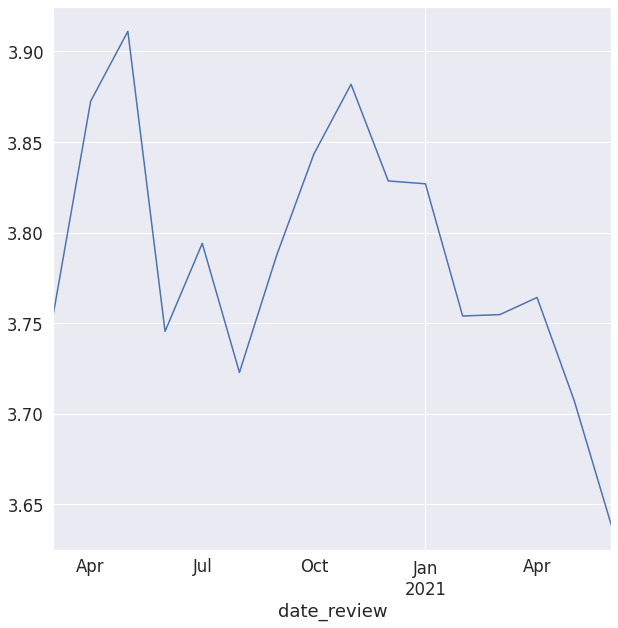

In [ ]:
df_glassdoor_covid_graph.plot()


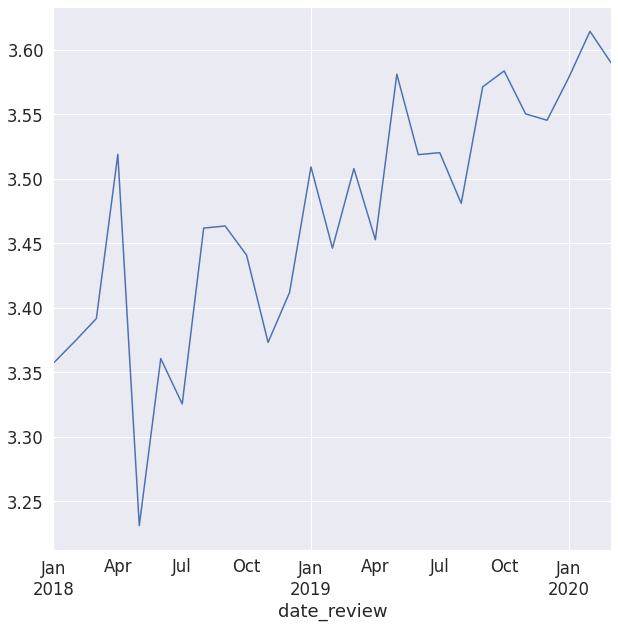

In [ ]:
df_glassdoor_precovid_graph.plot()


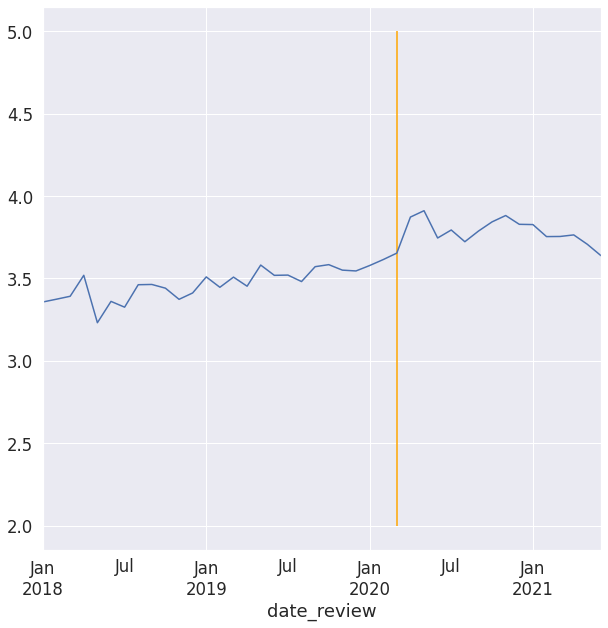

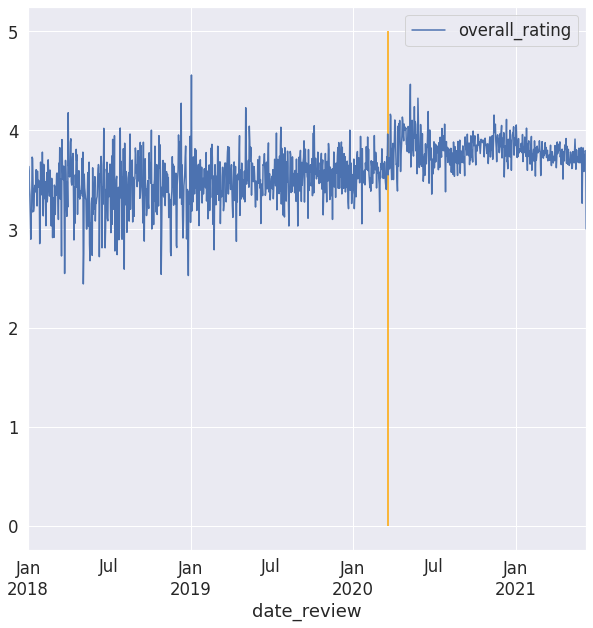

In [ ]:
df_glassdoor_time_graph.plot()
plt.vlines(x = lockdown_start,ymin=2, ymax=5, colors = 'orange', label = 'Covid Start')
df_glassdoor_time_graph_by_day.plot()
plt.vlines(x = lockdown_start,ymin=0, ymax=5, colors = 'orange', label = 'Covid Start')

In [ ]:
df_glassdoor_covid_status = df_glassdoor_overall[['date_review', 'overall_rating']].copy()
df_glassdoor_covid_status['covid_status'] = df_glassdoor_covid_status['date_review'].apply(lambda x: "Pre-covid" if x < lockdown_start else "Covid")
df_glassdoor_covid_status
groups_covid_status = df_glassdoor_covid_status.groupby(by="covid_status")
covid_box_plot = pd.DataFrame()
for name, group in groups_covid_status:
  group['month_year'] = group['date_review'].dt.to_period('M')
  vals = group.drop(columns=['covid_status', 'date_review'])
  vals = vals.groupby(by='month_year', as_index=False).mean()
  # print(type(vals))
  # print((name))
  # print(vals.values)
  covid_box_plot[name] = vals[['overall_rating']]

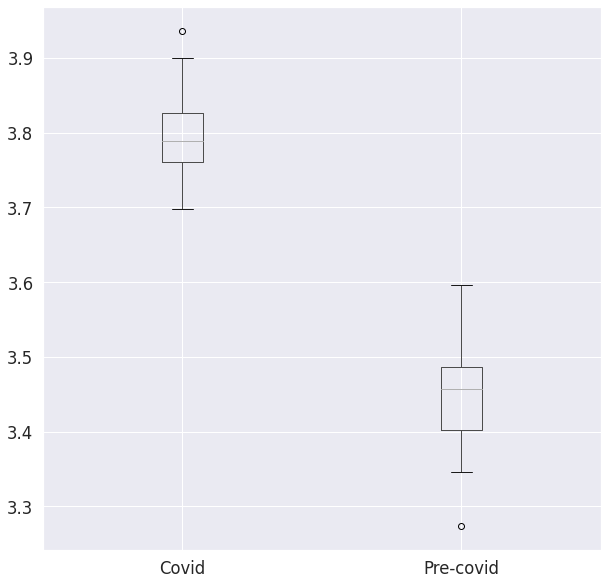

In [ ]:
covid_box_plot.boxplot()

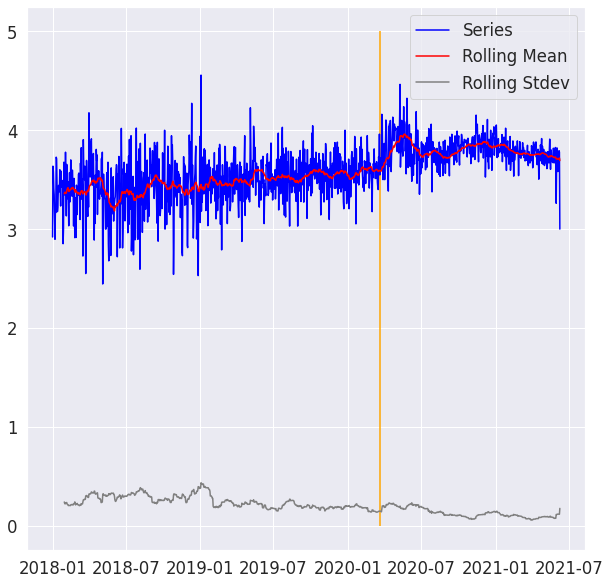

In [ ]:
series = df_glassdoor_overall[['date_review', 'overall_rating']].copy().groupby(by="date_review").mean()
rolling_mean = pd.Series.rolling(series,center=False,window=30).mean()
rolling_std = pd.Series.rolling(series,center=False,window=30).std()
plt.plot(series,color='blue',label='Series')
plt.plot(rolling_mean,color='red', label='Rolling Mean')
plt.plot(rolling_std,color='gray',label='Rolling Stdev')
plt.legend()
plt.vlines(x = lockdown_start,ymin=0, ymax=5, colors = 'orange', label = 'Covid Start')

did not use arima nor stationary b/c we are checking for change of one time event not sampling